# TOC
1. [Test](#test)

# What is this?

This is a Jupyter Notebook that demonstrates how Python can be used to explore the content of a DICOM dataset, which was converted into a collection of tables using this converter script: https://github.com/QIICR/dcm2tables

The DICOM dataset used in this demonstration is available publicly from The Cancer Imaging Archive (TCIA), and can be downloaded following the instructions here: https://wiki.cancerimagingarchive.net/display/Public/QIN-HEADNECK

## Data

The _QIN-HEADNECK_ collection is very large. For convenience, we ran the script mentioned above to create the tabular view of the dataset. These tables can be downloaded here: **TODO** (make sure to unzip the file!). 

For the reference, here is the time needed to generate tables from the DICOM datasets on a MacBook Pro:
* PET and CT series: ~ 50 minutes
* Derived series - SEG, RWV, and measurements SR: ~ 7 minutes
* Clinical SR: 

The schema of the tables is provided [here](https://app.quickdatabasediagrams.com/#/schema/_71V1H1AXEqqKWDnvx4VXw).

In a nutshell, here is a bird's eye view of the QIN-HEADNECK dataset (the details are available in [this publicly available manuscript](https://doi.org/10.7717/peerj.2057)): 
* 156 subjects with head and neck cancer
* each subject had one or more PET/CT study (each study is expected to include a CT and a PET imaging series) for disease staging and treatment response assessment
* images for a subset of subjects were analyzed to do the following:
 * segment the primary tumor and the involved lymph nodes: each of these areas was segmented by each of the two readers, on two occasions, using [3D Slicer](http://slicer.org) both manually and using an interactive automated segmentation tool described in [this publicly available paper](http://onlinelibrary.wiley.com/doi/10.1118/1.4948679/full)
 * segment reference regions for PET normalization: cerebellum, liver and aortic arch
 * extract quantitative measurements from the segmented regions



## Tools

In this demonstration we will use the following Python packages:
* Pandas for working with the tabular data
* numpy for numerical operations
* [matplotlib](https://matplotlib.org/index.html), [seaborn](https://seaborn.pydata.org/) and [bokeh](http://bokeh.pydata.org/en/latest/) for generating plots

If you are working with this notebook on your own system, you will need to install those packages as a prerequisite to import the packages!

# Multi-slice image data <a id="test"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First let's load three of the tables provided in the dataset. Note that all of the tables are linked by the _SOPInstanceUID_ that uniquely identifies every single DICOM dataset:
* **CompositeContext.csv** contains the common attributes related to the patient and study (e.g., dates, patient information) 
* **CT.csv** contains attributes specific to the DICOM CT modality objects (Computed Tomography)
* **PT.csv** contains attributes for the DICOM PT modality (Positron Emitted Tomography, or PET)

In [2]:
#clinical_df = pd.read_csv('CD9.tsv', sep='\t')
tablesPath = '/Users/fedorov/github/dcm2tables/QIN-HEADNECK-tables-no_clinical-Aug18'
CT_df = pd.read_csv(tablesPath+'/CT.tsv', sep='\t', low_memory=False)


In [3]:
PT_df = pd.read_csv(tablesPath+'/PT.tsv', sep='\t', low_memory=False)

In [4]:
CompositeContext_df=pd.read_csv(tablesPath+'/CompositeContext.tsv', sep='\t',low_memory=False)

Let's see what attributes are stored in each of the tables we just loaded.

**CompositeContext** table:

In [5]:
CompositeContext_df.columns

Index(['BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime'],
      dtype='object')

**CT** table:

In [6]:
CT_df.columns

Index(['Columns', 'ConvolutionKernel', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'Exposure', 'ExposureTime', 'FilterType',
       'FocalSpots', 'FrameOfReferenceUID', 'GeneratorPower',
       'ImageOrientationPatient', 'ImagePositionPatient', 'PixelSpacing',
       'ReconstructionDiameter', 'RotationDirection', 'Rows', 'SOPInstanceUID',
       'SliceThickness', 'XRayTubeCurrent'],
      dtype='object')

**PT** table:

In [7]:
PT_df.columns

Index(['Columns', 'ConvolutionKernel', 'FrameOfReferenceUID',
       'ImageOrientationPatient', 'ImagePositionPatient', 'PixelSpacing',
       'ReconstructionMethod', 'Rows', 'SOPInstanceUID', 'SliceThickness'],
      dtype='object')

## Basic validation of data consistency

Let's do a quick sanity check - let's confirm that the values of _SOPInstanceUID_ column are unique.

In [8]:
def checkDFValidity(df):
  return df.shape[0] == df['SOPInstanceUID'].unique().shape[0]

print("CT table valid: "+str(checkDFValidity(CT_df)))
print("PT table valid: "+str(checkDFValidity(PT_df)))
print("CompositeContext table valid: "+str(checkDFValidity(CompositeContext_df)))

CT table valid: True
PT table valid: True
CompositeContext table valid: True


Each imaging exam of the patient (DICOM study) is uniquely identified by a _SOP

In [9]:
CT_df=pd.merge(CT_df,CompositeContext_df,on="SOPInstanceUID")

In [10]:
PT_df=pd.merge(PT_df,CompositeContext_df,on="SOPInstanceUID")

In [11]:
CT_df.columns

Index(['Columns', 'ConvolutionKernel', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'Exposure', 'ExposureTime', 'FilterType',
       'FocalSpots', 'FrameOfReferenceUID', 'GeneratorPower',
       'ImageOrientationPatient', 'ImagePositionPatient', 'PixelSpacing',
       'ReconstructionDiameter', 'RotationDirection', 'Rows', 'SOPInstanceUID',
       'SliceThickness', 'XRayTubeCurrent', 'BodyPartExamined',
       'ManufacturerModelName', 'Modality', 'PatientAge', 'PatientID',
       'PatientName', 'PatientSex', 'PatientWeight', 'SOPClassUID',
       'SeriesDate', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesTime',
       'SoftwareVersions', 'StudyDate', 'StudyDescription', 'StudyInstanceUID',
       'StudyTime'],
      dtype='object')

In [12]:
CT_df['SeriesInstanceUID'].unique().shape  

(493,)

In [13]:
PT_df['SeriesInstanceUID'].unique().shape  

(484,)

In [33]:
PT_df[PT_df["SeriesInstanceUID"]=="1.3.6.1.4.1.14519.5.2.1.2744.7002.886851941687931416391879144903"].shape

(545, 28)

## Validation of geometric consistency

Typically, DICOM image data comes as a bunch of files with one file corresponding to one image slice (or DICOM _instance_). Typical image analysis tasks involve volumetrically reconstructed data. Volumetric reconstruction of the individual DICOM image series is typically the first task encountered in preparing DICOM data for the subsequent analysis.

It is important to be careful how this reconstruction is done. Each DICOM image instance contains two attributes that are needed for reconstructing the image volume: (for the reference, see [the definitions in the context of the DICOM standard](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html), and [further explanation](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html#sect_C.7.6.2.1.1)):
* _Image Position (Patient)_: The x, y, and z coordinates of the upper left hand corner (center of the first voxel transmitted) of the image, in mm. 
* _Image Orientation (Patient)_: The direction cosines of the first row and the first column with respect to the patient.

These are also illustrated in the sketch below:

![](https://www.dropbox.com/s/u9przjhynd1a0xc/position_orientation.jpg?raw=1)

A common fallacy in reconstructing image volume is in using DICOM _SliceThickness_ attribute. As discussed in [this blog post by David Clunue](http://dclunie.blogspot.com/2013/10/how-thick-am-i-sad-story-of-lonely-slice.html),

> _The slice interval is distinct from the slice "thickness" (Slice Thickness (0018,0050)), since data may be acquired and reconstructed such that there is either a gap between slices, or slices overlap_ 
> [...]
>
> _The slice interval is rarely encoded explicitly, and even if it is, may be unreliable, so one should compute the interval from the distance along the normal to the common orientation (parallel slices) using the Image Position (Patient) origin offset and the Image Orientation (Patient) row and column vectors._

The concept of slice interval is illustrated in the figure below. The idea is that given image orientation, we can compute the scan direction as a cross product of the orientation vectors, and then calculate slice interval between the individual slices using image position.

![](https://www.dropbox.com/s/gj4cm1th6sd1otq/slice_distances.jpg?raw=1)

This is what we are going to do next!

`geometryChecker` is a small python class that takes a pandas data frame corresponding to the instances of a single imaging series, and does the calculations mentioned above to obtain the slice interval, and confirm it is identical for all consecutive slices.

In [29]:
import geometryChecker, imp

# this is for convenience in case geometryChecker class is changed,
#  so that we don't need to restart the notebook
imp.reload(geometryChecker)

# take a dataframe that should include SeriesInstanceUID, 
#  SliceThickness, ImageOrientationPatient and ImagePositionPatient, and
#  check each series for geometric consistency. Also check how calculate 
# distance between slices compares with SliceThickness
def examineGeometryValidityPerSeries(df):
  seriesUIDs = pd.unique(df["SeriesInstanceUID"])
  locCnt = 0
  checks_df = pd.DataFrame(columns=["PatientID", "SeriesInstanceUID","computedSliceThickness","SliceThickness","geometryOK"])
  for seriesUID in seriesUIDs:
    series = df[df["SeriesInstanceUID"]==seriesUID]
    if seriesUID == "1.2.276.0.7230010.3.1.3.8323329.2405.1440003562.391081":
      print("Got it")
    print(series["PatientID"].unique)
    checker = geometryChecker.SeriesGeometryChecker(series)
    geometryOK = checker.geometryOK()
    checks_df.loc[locCnt] = [series["PatientID"].values[0], seriesUID,checker.computedSliceThickness,series["SliceThickness"].iloc[0],geometryOK]
    locCnt = locCnt+1
  return checks_df

ctGeometryChecks_df = examineGeometryValidityPerSeries(CT_df)
ptGeometryChecks_df = examineGeometryValidityPerSeries(PT_df)

0      QIN-HEADNECK-01-0003
1      QIN-HEADNECK-01-0003
2      QIN-HEADNECK-01-0003
3      QIN-HEADNECK-01-0003
4      QIN-HEADNECK-01-0003
5      QIN-HEADNECK-01-0003
6      QIN-HEADNECK-01-0003
7      QIN-HEADNECK-01-0003
8      QIN-HEADNECK-01-0003
9      QIN-HEADNECK-01-0003
10     QIN-HEADNECK-01-0003
11     QIN-HEADNECK-01-0003
12     QIN-HEADNECK-01-0003
13     QIN-HEADNECK-01-0003
14     QIN-HEADNECK-01-0003
15     QIN-HEADNECK-01-0003
16     QIN-HEADNECK-01-0003
17     QIN-HEADNECK-01-0003
18     QIN-HEADNECK-01-0003
19     QIN-HEADNECK-01-0003
20     QIN-HEADNECK-01-0003
21     QIN-HEADNECK-01-0003
22     QIN-HEADNECK-01-0003
23     QIN-HEADNECK-01-0003
24     QIN-HEADNECK-01-0003
25     QIN-HEADNECK-01-0003
26     QIN-HEADNECK-01-0003
27     QIN-HEADNECK-01-0003
28     QIN-HEADNECK-01-0003
29     QIN-HEADNECK-01-0003
               ...         
160    QIN-HEADNECK-01-0003
161    QIN-HEADNECK-01-0003
162    QIN-HEADNECK-01-0003
163    QIN-HEADNECK-01-0003
164    QIN-HEADNECK-

Name: PatientID, Length: 297, dtype: object
2228    QIN-HEADNECK-01-0007
2229    QIN-HEADNECK-01-0007
2230    QIN-HEADNECK-01-0007
2231    QIN-HEADNECK-01-0007
2232    QIN-HEADNECK-01-0007
2233    QIN-HEADNECK-01-0007
2234    QIN-HEADNECK-01-0007
2235    QIN-HEADNECK-01-0007
2236    QIN-HEADNECK-01-0007
2237    QIN-HEADNECK-01-0007
2238    QIN-HEADNECK-01-0007
2239    QIN-HEADNECK-01-0007
2240    QIN-HEADNECK-01-0007
2241    QIN-HEADNECK-01-0007
2242    QIN-HEADNECK-01-0007
2243    QIN-HEADNECK-01-0007
2244    QIN-HEADNECK-01-0007
2245    QIN-HEADNECK-01-0007
2246    QIN-HEADNECK-01-0007
2247    QIN-HEADNECK-01-0007
2248    QIN-HEADNECK-01-0007
2249    QIN-HEADNECK-01-0007
2250    QIN-HEADNECK-01-0007
2251    QIN-HEADNECK-01-0007
2252    QIN-HEADNECK-01-0007
2253    QIN-HEADNECK-01-0007
2254    QIN-HEADNECK-01-0007
2255    QIN-HEADNECK-01-0007
2256    QIN-HEADNECK-01-0007
2257    QIN-HEADNECK-01-0007
                ...         
2692    QIN-HEADNECK-01-0007
2693    QIN-HEADNECK-01-0007

Name: PatientID, Length: 435, dtype: object
5305    QIN-HEADNECK-01-0011
5306    QIN-HEADNECK-01-0011
5307    QIN-HEADNECK-01-0011
5308    QIN-HEADNECK-01-0011
5309    QIN-HEADNECK-01-0011
5310    QIN-HEADNECK-01-0011
5311    QIN-HEADNECK-01-0011
5312    QIN-HEADNECK-01-0011
5313    QIN-HEADNECK-01-0011
5314    QIN-HEADNECK-01-0011
5315    QIN-HEADNECK-01-0011
5316    QIN-HEADNECK-01-0011
5317    QIN-HEADNECK-01-0011
5318    QIN-HEADNECK-01-0011
5319    QIN-HEADNECK-01-0011
5320    QIN-HEADNECK-01-0011
5321    QIN-HEADNECK-01-0011
5322    QIN-HEADNECK-01-0011
5323    QIN-HEADNECK-01-0011
5324    QIN-HEADNECK-01-0011
5325    QIN-HEADNECK-01-0011
5326    QIN-HEADNECK-01-0011
5327    QIN-HEADNECK-01-0011
5328    QIN-HEADNECK-01-0011
5329    QIN-HEADNECK-01-0011
5330    QIN-HEADNECK-01-0011
5331    QIN-HEADNECK-01-0011
5332    QIN-HEADNECK-01-0011
5333    QIN-HEADNECK-01-0011
5334    QIN-HEADNECK-01-0011
                ...         
5465    QIN-HEADNECK-01-0011
5466    QIN-HEADNECK-01-0011

Name: PatientID, Length: 226, dtype: object
7813    QIN-HEADNECK-01-0020
7814    QIN-HEADNECK-01-0020
7815    QIN-HEADNECK-01-0020
7816    QIN-HEADNECK-01-0020
7817    QIN-HEADNECK-01-0020
7818    QIN-HEADNECK-01-0020
7819    QIN-HEADNECK-01-0020
7820    QIN-HEADNECK-01-0020
7821    QIN-HEADNECK-01-0020
7822    QIN-HEADNECK-01-0020
7823    QIN-HEADNECK-01-0020
7824    QIN-HEADNECK-01-0020
7825    QIN-HEADNECK-01-0020
7826    QIN-HEADNECK-01-0020
7827    QIN-HEADNECK-01-0020
7828    QIN-HEADNECK-01-0020
7829    QIN-HEADNECK-01-0020
7830    QIN-HEADNECK-01-0020
7831    QIN-HEADNECK-01-0020
7832    QIN-HEADNECK-01-0020
7833    QIN-HEADNECK-01-0020
7834    QIN-HEADNECK-01-0020
7835    QIN-HEADNECK-01-0020
7836    QIN-HEADNECK-01-0020
7837    QIN-HEADNECK-01-0020
7838    QIN-HEADNECK-01-0020
7839    QIN-HEADNECK-01-0020
7840    QIN-HEADNECK-01-0020
7841    QIN-HEADNECK-01-0020
7842    QIN-HEADNECK-01-0020
                ...         
8277    QIN-HEADNECK-01-0020
8278    QIN-HEADNECK-01-0020

10953    QIN-HEADNECK-01-0023
10954    QIN-HEADNECK-01-0023
10955    QIN-HEADNECK-01-0023
10956    QIN-HEADNECK-01-0023
10957    QIN-HEADNECK-01-0023
10958    QIN-HEADNECK-01-0023
10959    QIN-HEADNECK-01-0023
10960    QIN-HEADNECK-01-0023
10961    QIN-HEADNECK-01-0023
10962    QIN-HEADNECK-01-0023
10963    QIN-HEADNECK-01-0023
10964    QIN-HEADNECK-01-0023
10965    QIN-HEADNECK-01-0023
10966    QIN-HEADNECK-01-0023
10967    QIN-HEADNECK-01-0023
10968    QIN-HEADNECK-01-0023
10969    QIN-HEADNECK-01-0023
10970    QIN-HEADNECK-01-0023
10971    QIN-HEADNECK-01-0023
10972    QIN-HEADNECK-01-0023
10973    QIN-HEADNECK-01-0023
10974    QIN-HEADNECK-01-0023
10975    QIN-HEADNECK-01-0023
10976    QIN-HEADNECK-01-0023
10977    QIN-HEADNECK-01-0023
10978    QIN-HEADNECK-01-0023
10979    QIN-HEADNECK-01-0023
10980    QIN-HEADNECK-01-0023
10981    QIN-HEADNECK-01-0023
10982    QIN-HEADNECK-01-0023
                 ...         
11185    QIN-HEADNECK-01-0023
11186    QIN-HEADNECK-01-0023
11187    Q

Name: PatientID, Length: 297, dtype: object
13771    QIN-HEADNECK-01-0027
13772    QIN-HEADNECK-01-0027
13773    QIN-HEADNECK-01-0027
13774    QIN-HEADNECK-01-0027
13775    QIN-HEADNECK-01-0027
13776    QIN-HEADNECK-01-0027
13777    QIN-HEADNECK-01-0027
13778    QIN-HEADNECK-01-0027
13779    QIN-HEADNECK-01-0027
13780    QIN-HEADNECK-01-0027
13781    QIN-HEADNECK-01-0027
13782    QIN-HEADNECK-01-0027
13783    QIN-HEADNECK-01-0027
13784    QIN-HEADNECK-01-0027
13785    QIN-HEADNECK-01-0027
13786    QIN-HEADNECK-01-0027
13787    QIN-HEADNECK-01-0027
13788    QIN-HEADNECK-01-0027
13789    QIN-HEADNECK-01-0027
13790    QIN-HEADNECK-01-0027
13791    QIN-HEADNECK-01-0027
13792    QIN-HEADNECK-01-0027
13793    QIN-HEADNECK-01-0027
13794    QIN-HEADNECK-01-0027
13795    QIN-HEADNECK-01-0027
13796    QIN-HEADNECK-01-0027
13797    QIN-HEADNECK-01-0027
13798    QIN-HEADNECK-01-0027
13799    QIN-HEADNECK-01-0027
13800    QIN-HEADNECK-01-0027
                 ...         
14038    QIN-HEADNECK-01-0

Name: PatientID, Length: 297, dtype: object
16886    QIN-HEADNECK-01-0036
16887    QIN-HEADNECK-01-0036
16888    QIN-HEADNECK-01-0036
16889    QIN-HEADNECK-01-0036
16890    QIN-HEADNECK-01-0036
16891    QIN-HEADNECK-01-0036
16892    QIN-HEADNECK-01-0036
16893    QIN-HEADNECK-01-0036
16894    QIN-HEADNECK-01-0036
16895    QIN-HEADNECK-01-0036
16896    QIN-HEADNECK-01-0036
16897    QIN-HEADNECK-01-0036
16898    QIN-HEADNECK-01-0036
16899    QIN-HEADNECK-01-0036
16900    QIN-HEADNECK-01-0036
16901    QIN-HEADNECK-01-0036
16902    QIN-HEADNECK-01-0036
16903    QIN-HEADNECK-01-0036
16904    QIN-HEADNECK-01-0036
16905    QIN-HEADNECK-01-0036
16906    QIN-HEADNECK-01-0036
16907    QIN-HEADNECK-01-0036
16908    QIN-HEADNECK-01-0036
16909    QIN-HEADNECK-01-0036
16910    QIN-HEADNECK-01-0036
16911    QIN-HEADNECK-01-0036
16912    QIN-HEADNECK-01-0036
16913    QIN-HEADNECK-01-0036
16914    QIN-HEADNECK-01-0036
16915    QIN-HEADNECK-01-0036
                 ...         
17291    QIN-HEADNECK-01-0

19913    QIN-HEADNECK-01-0040
19914    QIN-HEADNECK-01-0040
19915    QIN-HEADNECK-01-0040
19916    QIN-HEADNECK-01-0040
19917    QIN-HEADNECK-01-0040
19918    QIN-HEADNECK-01-0040
19919    QIN-HEADNECK-01-0040
19920    QIN-HEADNECK-01-0040
19921    QIN-HEADNECK-01-0040
19922    QIN-HEADNECK-01-0040
19923    QIN-HEADNECK-01-0040
19924    QIN-HEADNECK-01-0040
19925    QIN-HEADNECK-01-0040
19926    QIN-HEADNECK-01-0040
19927    QIN-HEADNECK-01-0040
19928    QIN-HEADNECK-01-0040
19929    QIN-HEADNECK-01-0040
19930    QIN-HEADNECK-01-0040
19931    QIN-HEADNECK-01-0040
19932    QIN-HEADNECK-01-0040
19933    QIN-HEADNECK-01-0040
19934    QIN-HEADNECK-01-0040
19935    QIN-HEADNECK-01-0040
19936    QIN-HEADNECK-01-0040
19937    QIN-HEADNECK-01-0040
19938    QIN-HEADNECK-01-0040
19939    QIN-HEADNECK-01-0040
19940    QIN-HEADNECK-01-0040
19941    QIN-HEADNECK-01-0040
19942    QIN-HEADNECK-01-0040
                 ...         
20180    QIN-HEADNECK-01-0040
20181    QIN-HEADNECK-01-0040
20182    Q

23245    QIN-HEADNECK-01-0043
23246    QIN-HEADNECK-01-0043
23247    QIN-HEADNECK-01-0043
23248    QIN-HEADNECK-01-0043
23249    QIN-HEADNECK-01-0043
23250    QIN-HEADNECK-01-0043
23251    QIN-HEADNECK-01-0043
23252    QIN-HEADNECK-01-0043
23253    QIN-HEADNECK-01-0043
23254    QIN-HEADNECK-01-0043
23255    QIN-HEADNECK-01-0043
23256    QIN-HEADNECK-01-0043
23257    QIN-HEADNECK-01-0043
23258    QIN-HEADNECK-01-0043
23259    QIN-HEADNECK-01-0043
23260    QIN-HEADNECK-01-0043
23261    QIN-HEADNECK-01-0043
23262    QIN-HEADNECK-01-0043
23263    QIN-HEADNECK-01-0043
23264    QIN-HEADNECK-01-0043
23265    QIN-HEADNECK-01-0043
23266    QIN-HEADNECK-01-0043
23267    QIN-HEADNECK-01-0043
23268    QIN-HEADNECK-01-0043
23269    QIN-HEADNECK-01-0043
23270    QIN-HEADNECK-01-0043
23271    QIN-HEADNECK-01-0043
23272    QIN-HEADNECK-01-0043
23273    QIN-HEADNECK-01-0043
23274    QIN-HEADNECK-01-0043
                 ...         
23512    QIN-HEADNECK-01-0043
23513    QIN-HEADNECK-01-0043
23514    Q

Name: PatientID, Length: 297, dtype: object
26152    QIN-HEADNECK-01-0047
26153    QIN-HEADNECK-01-0047
26154    QIN-HEADNECK-01-0047
26155    QIN-HEADNECK-01-0047
26156    QIN-HEADNECK-01-0047
26157    QIN-HEADNECK-01-0047
26158    QIN-HEADNECK-01-0047
26159    QIN-HEADNECK-01-0047
26160    QIN-HEADNECK-01-0047
26161    QIN-HEADNECK-01-0047
26162    QIN-HEADNECK-01-0047
26163    QIN-HEADNECK-01-0047
26164    QIN-HEADNECK-01-0047
26165    QIN-HEADNECK-01-0047
26166    QIN-HEADNECK-01-0047
26167    QIN-HEADNECK-01-0047
26168    QIN-HEADNECK-01-0047
26169    QIN-HEADNECK-01-0047
26170    QIN-HEADNECK-01-0047
26171    QIN-HEADNECK-01-0047
26172    QIN-HEADNECK-01-0047
26173    QIN-HEADNECK-01-0047
26174    QIN-HEADNECK-01-0047
26175    QIN-HEADNECK-01-0047
26176    QIN-HEADNECK-01-0047
26177    QIN-HEADNECK-01-0047
26178    QIN-HEADNECK-01-0047
26179    QIN-HEADNECK-01-0047
26180    QIN-HEADNECK-01-0047
26181    QIN-HEADNECK-01-0047
                 ...         
26419    QIN-HEADNECK-01-0

29334    QIN-HEADNECK-01-0050
29335    QIN-HEADNECK-01-0050
29336    QIN-HEADNECK-01-0050
29337    QIN-HEADNECK-01-0050
29338    QIN-HEADNECK-01-0050
29339    QIN-HEADNECK-01-0050
29340    QIN-HEADNECK-01-0050
29341    QIN-HEADNECK-01-0050
29342    QIN-HEADNECK-01-0050
29343    QIN-HEADNECK-01-0050
29344    QIN-HEADNECK-01-0050
29345    QIN-HEADNECK-01-0050
29346    QIN-HEADNECK-01-0050
29347    QIN-HEADNECK-01-0050
29348    QIN-HEADNECK-01-0050
29349    QIN-HEADNECK-01-0050
29350    QIN-HEADNECK-01-0050
29351    QIN-HEADNECK-01-0050
29352    QIN-HEADNECK-01-0050
29353    QIN-HEADNECK-01-0050
29354    QIN-HEADNECK-01-0050
29355    QIN-HEADNECK-01-0050
29356    QIN-HEADNECK-01-0050
29357    QIN-HEADNECK-01-0050
29358    QIN-HEADNECK-01-0050
29359    QIN-HEADNECK-01-0050
29360    QIN-HEADNECK-01-0050
29361    QIN-HEADNECK-01-0050
29362    QIN-HEADNECK-01-0050
29363    QIN-HEADNECK-01-0050
                 ...         
29739    QIN-HEADNECK-01-0050
29740    QIN-HEADNECK-01-0050
29741    Q

Name: PatientID, Length: 297, dtype: object
32728    QIN-HEADNECK-01-0052
32729    QIN-HEADNECK-01-0052
32730    QIN-HEADNECK-01-0052
32731    QIN-HEADNECK-01-0052
32732    QIN-HEADNECK-01-0052
32733    QIN-HEADNECK-01-0052
32734    QIN-HEADNECK-01-0052
32735    QIN-HEADNECK-01-0052
32736    QIN-HEADNECK-01-0052
32737    QIN-HEADNECK-01-0052
32738    QIN-HEADNECK-01-0052
32739    QIN-HEADNECK-01-0052
32740    QIN-HEADNECK-01-0052
32741    QIN-HEADNECK-01-0052
32742    QIN-HEADNECK-01-0052
32743    QIN-HEADNECK-01-0052
32744    QIN-HEADNECK-01-0052
32745    QIN-HEADNECK-01-0052
32746    QIN-HEADNECK-01-0052
32747    QIN-HEADNECK-01-0052
32748    QIN-HEADNECK-01-0052
32749    QIN-HEADNECK-01-0052
32750    QIN-HEADNECK-01-0052
32751    QIN-HEADNECK-01-0052
32752    QIN-HEADNECK-01-0052
32753    QIN-HEADNECK-01-0052
32754    QIN-HEADNECK-01-0052
32755    QIN-HEADNECK-01-0052
32756    QIN-HEADNECK-01-0052
32757    QIN-HEADNECK-01-0052
                 ...         
32995    QIN-HEADNECK-01-0

Name: PatientID, Length: 494, dtype: object
35957    QIN-HEADNECK-01-0056
35958    QIN-HEADNECK-01-0056
35959    QIN-HEADNECK-01-0056
35960    QIN-HEADNECK-01-0056
35961    QIN-HEADNECK-01-0056
35962    QIN-HEADNECK-01-0056
35963    QIN-HEADNECK-01-0056
35964    QIN-HEADNECK-01-0056
35965    QIN-HEADNECK-01-0056
35966    QIN-HEADNECK-01-0056
35967    QIN-HEADNECK-01-0056
35968    QIN-HEADNECK-01-0056
35969    QIN-HEADNECK-01-0056
35970    QIN-HEADNECK-01-0056
35971    QIN-HEADNECK-01-0056
35972    QIN-HEADNECK-01-0056
35973    QIN-HEADNECK-01-0056
35974    QIN-HEADNECK-01-0056
35975    QIN-HEADNECK-01-0056
35976    QIN-HEADNECK-01-0056
35977    QIN-HEADNECK-01-0056
35978    QIN-HEADNECK-01-0056
35979    QIN-HEADNECK-01-0056
35980    QIN-HEADNECK-01-0056
35981    QIN-HEADNECK-01-0056
35982    QIN-HEADNECK-01-0056
35983    QIN-HEADNECK-01-0056
35984    QIN-HEADNECK-01-0056
35985    QIN-HEADNECK-01-0056
35986    QIN-HEADNECK-01-0056
                 ...         
36224    QIN-HEADNECK-01-0

Name: PatientID, Length: 262, dtype: object
39368    QIN-HEADNECK-01-0060
39369    QIN-HEADNECK-01-0060
39370    QIN-HEADNECK-01-0060
39371    QIN-HEADNECK-01-0060
39372    QIN-HEADNECK-01-0060
39373    QIN-HEADNECK-01-0060
39374    QIN-HEADNECK-01-0060
39375    QIN-HEADNECK-01-0060
39376    QIN-HEADNECK-01-0060
39377    QIN-HEADNECK-01-0060
39378    QIN-HEADNECK-01-0060
39379    QIN-HEADNECK-01-0060
39380    QIN-HEADNECK-01-0060
39381    QIN-HEADNECK-01-0060
39382    QIN-HEADNECK-01-0060
39383    QIN-HEADNECK-01-0060
39384    QIN-HEADNECK-01-0060
39385    QIN-HEADNECK-01-0060
39386    QIN-HEADNECK-01-0060
39387    QIN-HEADNECK-01-0060
39388    QIN-HEADNECK-01-0060
39389    QIN-HEADNECK-01-0060
39390    QIN-HEADNECK-01-0060
39391    QIN-HEADNECK-01-0060
39392    QIN-HEADNECK-01-0060
39393    QIN-HEADNECK-01-0060
39394    QIN-HEADNECK-01-0060
39395    QIN-HEADNECK-01-0060
39396    QIN-HEADNECK-01-0060
39397    QIN-HEADNECK-01-0060
                 ...         
39832    QIN-HEADNECK-01-0

43080    QIN-HEADNECK-01-0062
43081    QIN-HEADNECK-01-0062
43082    QIN-HEADNECK-01-0062
43083    QIN-HEADNECK-01-0062
43084    QIN-HEADNECK-01-0062
43085    QIN-HEADNECK-01-0062
43086    QIN-HEADNECK-01-0062
43087    QIN-HEADNECK-01-0062
43088    QIN-HEADNECK-01-0062
43089    QIN-HEADNECK-01-0062
43090    QIN-HEADNECK-01-0062
43091    QIN-HEADNECK-01-0062
43092    QIN-HEADNECK-01-0062
43093    QIN-HEADNECK-01-0062
43094    QIN-HEADNECK-01-0062
43095    QIN-HEADNECK-01-0062
43096    QIN-HEADNECK-01-0062
43097    QIN-HEADNECK-01-0062
43098    QIN-HEADNECK-01-0062
43099    QIN-HEADNECK-01-0062
43100    QIN-HEADNECK-01-0062
43101    QIN-HEADNECK-01-0062
43102    QIN-HEADNECK-01-0062
43103    QIN-HEADNECK-01-0062
43104    QIN-HEADNECK-01-0062
43105    QIN-HEADNECK-01-0062
43106    QIN-HEADNECK-01-0062
43107    QIN-HEADNECK-01-0062
43108    QIN-HEADNECK-01-0062
43109    QIN-HEADNECK-01-0062
                 ...         
43347    QIN-HEADNECK-01-0062
43348    QIN-HEADNECK-01-0062
43349    Q

46506    QIN-HEADNECK-01-0065
46507    QIN-HEADNECK-01-0065
46508    QIN-HEADNECK-01-0065
46509    QIN-HEADNECK-01-0065
46510    QIN-HEADNECK-01-0065
46511    QIN-HEADNECK-01-0065
46512    QIN-HEADNECK-01-0065
46513    QIN-HEADNECK-01-0065
46514    QIN-HEADNECK-01-0065
46515    QIN-HEADNECK-01-0065
46516    QIN-HEADNECK-01-0065
46517    QIN-HEADNECK-01-0065
46518    QIN-HEADNECK-01-0065
46519    QIN-HEADNECK-01-0065
46520    QIN-HEADNECK-01-0065
46521    QIN-HEADNECK-01-0065
46522    QIN-HEADNECK-01-0065
46523    QIN-HEADNECK-01-0065
46524    QIN-HEADNECK-01-0065
46525    QIN-HEADNECK-01-0065
46526    QIN-HEADNECK-01-0065
46527    QIN-HEADNECK-01-0065
46528    QIN-HEADNECK-01-0065
46529    QIN-HEADNECK-01-0065
46530    QIN-HEADNECK-01-0065
46531    QIN-HEADNECK-01-0065
46532    QIN-HEADNECK-01-0065
46533    QIN-HEADNECK-01-0065
46534    QIN-HEADNECK-01-0065
46535    QIN-HEADNECK-01-0065
                 ...         
46970    QIN-HEADNECK-01-0065
46971    QIN-HEADNECK-01-0065
46972    Q

49737    QIN-HEADNECK-01-0068
49738    QIN-HEADNECK-01-0068
49739    QIN-HEADNECK-01-0068
49740    QIN-HEADNECK-01-0068
49741    QIN-HEADNECK-01-0068
49742    QIN-HEADNECK-01-0068
49743    QIN-HEADNECK-01-0068
49744    QIN-HEADNECK-01-0068
49745    QIN-HEADNECK-01-0068
49746    QIN-HEADNECK-01-0068
49747    QIN-HEADNECK-01-0068
49748    QIN-HEADNECK-01-0068
49749    QIN-HEADNECK-01-0068
49750    QIN-HEADNECK-01-0068
49751    QIN-HEADNECK-01-0068
49752    QIN-HEADNECK-01-0068
49753    QIN-HEADNECK-01-0068
49754    QIN-HEADNECK-01-0068
49755    QIN-HEADNECK-01-0068
49756    QIN-HEADNECK-01-0068
49757    QIN-HEADNECK-01-0068
49758    QIN-HEADNECK-01-0068
49759    QIN-HEADNECK-01-0068
49760    QIN-HEADNECK-01-0068
49761    QIN-HEADNECK-01-0068
49762    QIN-HEADNECK-01-0068
49763    QIN-HEADNECK-01-0068
49764    QIN-HEADNECK-01-0068
49765    QIN-HEADNECK-01-0068
49766    QIN-HEADNECK-01-0068
                 ...         
50142    QIN-HEADNECK-01-0068
50143    QIN-HEADNECK-01-0068
50144    Q

53359    QIN-HEADNECK-01-0074
53360    QIN-HEADNECK-01-0074
53361    QIN-HEADNECK-01-0074
53362    QIN-HEADNECK-01-0074
53363    QIN-HEADNECK-01-0074
53364    QIN-HEADNECK-01-0074
53365    QIN-HEADNECK-01-0074
53366    QIN-HEADNECK-01-0074
53367    QIN-HEADNECK-01-0074
53368    QIN-HEADNECK-01-0074
53369    QIN-HEADNECK-01-0074
53370    QIN-HEADNECK-01-0074
53371    QIN-HEADNECK-01-0074
53372    QIN-HEADNECK-01-0074
53373    QIN-HEADNECK-01-0074
53374    QIN-HEADNECK-01-0074
53375    QIN-HEADNECK-01-0074
53376    QIN-HEADNECK-01-0074
53377    QIN-HEADNECK-01-0074
53378    QIN-HEADNECK-01-0074
53379    QIN-HEADNECK-01-0074
53380    QIN-HEADNECK-01-0074
53381    QIN-HEADNECK-01-0074
53382    QIN-HEADNECK-01-0074
53383    QIN-HEADNECK-01-0074
53384    QIN-HEADNECK-01-0074
53385    QIN-HEADNECK-01-0074
53386    QIN-HEADNECK-01-0074
53387    QIN-HEADNECK-01-0074
53388    QIN-HEADNECK-01-0074
                 ...         
53626    QIN-HEADNECK-01-0074
53627    QIN-HEADNECK-01-0074
53628    Q

56291    QIN-HEADNECK-01-0075
56292    QIN-HEADNECK-01-0075
56293    QIN-HEADNECK-01-0075
56294    QIN-HEADNECK-01-0075
56295    QIN-HEADNECK-01-0075
56296    QIN-HEADNECK-01-0075
56297    QIN-HEADNECK-01-0075
56298    QIN-HEADNECK-01-0075
56299    QIN-HEADNECK-01-0075
56300    QIN-HEADNECK-01-0075
56301    QIN-HEADNECK-01-0075
56302    QIN-HEADNECK-01-0075
56303    QIN-HEADNECK-01-0075
56304    QIN-HEADNECK-01-0075
56305    QIN-HEADNECK-01-0075
56306    QIN-HEADNECK-01-0075
56307    QIN-HEADNECK-01-0075
56308    QIN-HEADNECK-01-0075
56309    QIN-HEADNECK-01-0075
56310    QIN-HEADNECK-01-0075
56311    QIN-HEADNECK-01-0075
56312    QIN-HEADNECK-01-0075
56313    QIN-HEADNECK-01-0075
56314    QIN-HEADNECK-01-0075
56315    QIN-HEADNECK-01-0075
56316    QIN-HEADNECK-01-0075
56317    QIN-HEADNECK-01-0075
56318    QIN-HEADNECK-01-0075
56319    QIN-HEADNECK-01-0075
56320    QIN-HEADNECK-01-0075
                 ...         
56755    QIN-HEADNECK-01-0075
56756    QIN-HEADNECK-01-0075
56757    Q

Name: PatientID, Length: 494, dtype: object
60052    QIN-HEADNECK-01-0078
60053    QIN-HEADNECK-01-0078
60054    QIN-HEADNECK-01-0078
60055    QIN-HEADNECK-01-0078
60056    QIN-HEADNECK-01-0078
60057    QIN-HEADNECK-01-0078
60058    QIN-HEADNECK-01-0078
60059    QIN-HEADNECK-01-0078
60060    QIN-HEADNECK-01-0078
60061    QIN-HEADNECK-01-0078
60062    QIN-HEADNECK-01-0078
60063    QIN-HEADNECK-01-0078
60064    QIN-HEADNECK-01-0078
60065    QIN-HEADNECK-01-0078
60066    QIN-HEADNECK-01-0078
60067    QIN-HEADNECK-01-0078
60068    QIN-HEADNECK-01-0078
60069    QIN-HEADNECK-01-0078
60070    QIN-HEADNECK-01-0078
60071    QIN-HEADNECK-01-0078
60072    QIN-HEADNECK-01-0078
60073    QIN-HEADNECK-01-0078
60074    QIN-HEADNECK-01-0078
60075    QIN-HEADNECK-01-0078
60076    QIN-HEADNECK-01-0078
60077    QIN-HEADNECK-01-0078
60078    QIN-HEADNECK-01-0078
60079    QIN-HEADNECK-01-0078
60080    QIN-HEADNECK-01-0078
60081    QIN-HEADNECK-01-0078
                 ...         
60516    QIN-HEADNECK-01-0

Name: PatientID, Length: 552, dtype: object
63726    QIN-HEADNECK-01-0080
63727    QIN-HEADNECK-01-0080
63728    QIN-HEADNECK-01-0080
63729    QIN-HEADNECK-01-0080
63730    QIN-HEADNECK-01-0080
63731    QIN-HEADNECK-01-0080
63732    QIN-HEADNECK-01-0080
63733    QIN-HEADNECK-01-0080
63734    QIN-HEADNECK-01-0080
63735    QIN-HEADNECK-01-0080
63736    QIN-HEADNECK-01-0080
63737    QIN-HEADNECK-01-0080
63738    QIN-HEADNECK-01-0080
63739    QIN-HEADNECK-01-0080
63740    QIN-HEADNECK-01-0080
63741    QIN-HEADNECK-01-0080
63742    QIN-HEADNECK-01-0080
63743    QIN-HEADNECK-01-0080
63744    QIN-HEADNECK-01-0080
63745    QIN-HEADNECK-01-0080
63746    QIN-HEADNECK-01-0080
63747    QIN-HEADNECK-01-0080
63748    QIN-HEADNECK-01-0080
63749    QIN-HEADNECK-01-0080
63750    QIN-HEADNECK-01-0080
63751    QIN-HEADNECK-01-0080
63752    QIN-HEADNECK-01-0080
63753    QIN-HEADNECK-01-0080
63754    QIN-HEADNECK-01-0080
63755    QIN-HEADNECK-01-0080
                 ...         
64190    QIN-HEADNECK-01-0

Name: PatientID, Length: 494, dtype: object
67801    QIN-HEADNECK-01-0084
67802    QIN-HEADNECK-01-0084
67803    QIN-HEADNECK-01-0084
67804    QIN-HEADNECK-01-0084
67805    QIN-HEADNECK-01-0084
67806    QIN-HEADNECK-01-0084
67807    QIN-HEADNECK-01-0084
67808    QIN-HEADNECK-01-0084
67809    QIN-HEADNECK-01-0084
67810    QIN-HEADNECK-01-0084
67811    QIN-HEADNECK-01-0084
67812    QIN-HEADNECK-01-0084
67813    QIN-HEADNECK-01-0084
67814    QIN-HEADNECK-01-0084
67815    QIN-HEADNECK-01-0084
67816    QIN-HEADNECK-01-0084
67817    QIN-HEADNECK-01-0084
67818    QIN-HEADNECK-01-0084
67819    QIN-HEADNECK-01-0084
67820    QIN-HEADNECK-01-0084
67821    QIN-HEADNECK-01-0084
67822    QIN-HEADNECK-01-0084
67823    QIN-HEADNECK-01-0084
67824    QIN-HEADNECK-01-0084
67825    QIN-HEADNECK-01-0084
67826    QIN-HEADNECK-01-0084
67827    QIN-HEADNECK-01-0084
67828    QIN-HEADNECK-01-0084
67829    QIN-HEADNECK-01-0084
67830    QIN-HEADNECK-01-0084
                 ...         
68265    QIN-HEADNECK-01-0

71229    QIN-HEADNECK-01-0089
71230    QIN-HEADNECK-01-0089
71231    QIN-HEADNECK-01-0089
71232    QIN-HEADNECK-01-0089
71233    QIN-HEADNECK-01-0089
71234    QIN-HEADNECK-01-0089
71235    QIN-HEADNECK-01-0089
71236    QIN-HEADNECK-01-0089
71237    QIN-HEADNECK-01-0089
71238    QIN-HEADNECK-01-0089
71239    QIN-HEADNECK-01-0089
71240    QIN-HEADNECK-01-0089
71241    QIN-HEADNECK-01-0089
71242    QIN-HEADNECK-01-0089
71243    QIN-HEADNECK-01-0089
71244    QIN-HEADNECK-01-0089
71245    QIN-HEADNECK-01-0089
71246    QIN-HEADNECK-01-0089
71247    QIN-HEADNECK-01-0089
71248    QIN-HEADNECK-01-0089
71249    QIN-HEADNECK-01-0089
71250    QIN-HEADNECK-01-0089
71251    QIN-HEADNECK-01-0089
71252    QIN-HEADNECK-01-0089
71253    QIN-HEADNECK-01-0089
71254    QIN-HEADNECK-01-0089
71255    QIN-HEADNECK-01-0089
71256    QIN-HEADNECK-01-0089
71257    QIN-HEADNECK-01-0089
71258    QIN-HEADNECK-01-0089
                 ...         
71752    QIN-HEADNECK-01-0089
71753    QIN-HEADNECK-01-0089
71754    Q

74568    QIN-HEADNECK-01-0092
74569    QIN-HEADNECK-01-0092
74570    QIN-HEADNECK-01-0092
74571    QIN-HEADNECK-01-0092
74572    QIN-HEADNECK-01-0092
74573    QIN-HEADNECK-01-0092
74574    QIN-HEADNECK-01-0092
74575    QIN-HEADNECK-01-0092
74576    QIN-HEADNECK-01-0092
74577    QIN-HEADNECK-01-0092
74578    QIN-HEADNECK-01-0092
74579    QIN-HEADNECK-01-0092
74580    QIN-HEADNECK-01-0092
74581    QIN-HEADNECK-01-0092
74582    QIN-HEADNECK-01-0092
74583    QIN-HEADNECK-01-0092
74584    QIN-HEADNECK-01-0092
74585    QIN-HEADNECK-01-0092
74586    QIN-HEADNECK-01-0092
74587    QIN-HEADNECK-01-0092
74588    QIN-HEADNECK-01-0092
74589    QIN-HEADNECK-01-0092
74590    QIN-HEADNECK-01-0092
74591    QIN-HEADNECK-01-0092
74592    QIN-HEADNECK-01-0092
74593    QIN-HEADNECK-01-0092
74594    QIN-HEADNECK-01-0092
74595    QIN-HEADNECK-01-0092
74596    QIN-HEADNECK-01-0092
74597    QIN-HEADNECK-01-0092
                 ...         
75032    QIN-HEADNECK-01-0092
75033    QIN-HEADNECK-01-0092
75034    Q

Name: PatientID, Length: 494, dtype: object
78482    QIN-HEADNECK-01-0104
78483    QIN-HEADNECK-01-0104
78484    QIN-HEADNECK-01-0104
78485    QIN-HEADNECK-01-0104
78486    QIN-HEADNECK-01-0104
78487    QIN-HEADNECK-01-0104
78488    QIN-HEADNECK-01-0104
78489    QIN-HEADNECK-01-0104
78490    QIN-HEADNECK-01-0104
78491    QIN-HEADNECK-01-0104
78492    QIN-HEADNECK-01-0104
78493    QIN-HEADNECK-01-0104
78494    QIN-HEADNECK-01-0104
78495    QIN-HEADNECK-01-0104
78496    QIN-HEADNECK-01-0104
78497    QIN-HEADNECK-01-0104
78498    QIN-HEADNECK-01-0104
78499    QIN-HEADNECK-01-0104
78500    QIN-HEADNECK-01-0104
78501    QIN-HEADNECK-01-0104
78502    QIN-HEADNECK-01-0104
78503    QIN-HEADNECK-01-0104
78504    QIN-HEADNECK-01-0104
78505    QIN-HEADNECK-01-0104
78506    QIN-HEADNECK-01-0104
78507    QIN-HEADNECK-01-0104
78508    QIN-HEADNECK-01-0104
78509    QIN-HEADNECK-01-0104
78510    QIN-HEADNECK-01-0104
78511    QIN-HEADNECK-01-0104
                 ...         
79004    QIN-HEADNECK-01-0

Name: PatientID, Length: 494, dtype: object
82550    QIN-HEADNECK-01-0107
82551    QIN-HEADNECK-01-0107
82552    QIN-HEADNECK-01-0107
82553    QIN-HEADNECK-01-0107
82554    QIN-HEADNECK-01-0107
82555    QIN-HEADNECK-01-0107
82556    QIN-HEADNECK-01-0107
82557    QIN-HEADNECK-01-0107
82558    QIN-HEADNECK-01-0107
82559    QIN-HEADNECK-01-0107
82560    QIN-HEADNECK-01-0107
82561    QIN-HEADNECK-01-0107
82562    QIN-HEADNECK-01-0107
82563    QIN-HEADNECK-01-0107
82564    QIN-HEADNECK-01-0107
82565    QIN-HEADNECK-01-0107
82566    QIN-HEADNECK-01-0107
82567    QIN-HEADNECK-01-0107
82568    QIN-HEADNECK-01-0107
82569    QIN-HEADNECK-01-0107
82570    QIN-HEADNECK-01-0107
82571    QIN-HEADNECK-01-0107
82572    QIN-HEADNECK-01-0107
82573    QIN-HEADNECK-01-0107
82574    QIN-HEADNECK-01-0107
82575    QIN-HEADNECK-01-0107
82576    QIN-HEADNECK-01-0107
82577    QIN-HEADNECK-01-0107
82578    QIN-HEADNECK-01-0107
82579    QIN-HEADNECK-01-0107
                 ...         
82817    QIN-HEADNECK-01-0

Name: PatientID, Length: 552, dtype: object
86718    QIN-HEADNECK-01-0111
86719    QIN-HEADNECK-01-0111
86720    QIN-HEADNECK-01-0111
86721    QIN-HEADNECK-01-0111
86722    QIN-HEADNECK-01-0111
86723    QIN-HEADNECK-01-0111
86724    QIN-HEADNECK-01-0111
86725    QIN-HEADNECK-01-0111
86726    QIN-HEADNECK-01-0111
86727    QIN-HEADNECK-01-0111
86728    QIN-HEADNECK-01-0111
86729    QIN-HEADNECK-01-0111
86730    QIN-HEADNECK-01-0111
86731    QIN-HEADNECK-01-0111
86732    QIN-HEADNECK-01-0111
86733    QIN-HEADNECK-01-0111
86734    QIN-HEADNECK-01-0111
86735    QIN-HEADNECK-01-0111
86736    QIN-HEADNECK-01-0111
86737    QIN-HEADNECK-01-0111
86738    QIN-HEADNECK-01-0111
86739    QIN-HEADNECK-01-0111
86740    QIN-HEADNECK-01-0111
86741    QIN-HEADNECK-01-0111
86742    QIN-HEADNECK-01-0111
86743    QIN-HEADNECK-01-0111
86744    QIN-HEADNECK-01-0111
86745    QIN-HEADNECK-01-0111
86746    QIN-HEADNECK-01-0111
86747    QIN-HEADNECK-01-0111
                 ...         
87182    QIN-HEADNECK-01-0

Name: PatientID, Length: 435, dtype: object
90755    QIN-HEADNECK-01-0114
90756    QIN-HEADNECK-01-0114
90757    QIN-HEADNECK-01-0114
90758    QIN-HEADNECK-01-0114
90759    QIN-HEADNECK-01-0114
90760    QIN-HEADNECK-01-0114
90761    QIN-HEADNECK-01-0114
90762    QIN-HEADNECK-01-0114
90763    QIN-HEADNECK-01-0114
90764    QIN-HEADNECK-01-0114
90765    QIN-HEADNECK-01-0114
90766    QIN-HEADNECK-01-0114
90767    QIN-HEADNECK-01-0114
90768    QIN-HEADNECK-01-0114
90769    QIN-HEADNECK-01-0114
90770    QIN-HEADNECK-01-0114
90771    QIN-HEADNECK-01-0114
90772    QIN-HEADNECK-01-0114
90773    QIN-HEADNECK-01-0114
90774    QIN-HEADNECK-01-0114
90775    QIN-HEADNECK-01-0114
90776    QIN-HEADNECK-01-0114
90777    QIN-HEADNECK-01-0114
90778    QIN-HEADNECK-01-0114
90779    QIN-HEADNECK-01-0114
90780    QIN-HEADNECK-01-0114
90781    QIN-HEADNECK-01-0114
90782    QIN-HEADNECK-01-0114
90783    QIN-HEADNECK-01-0114
90784    QIN-HEADNECK-01-0114
                 ...         
91219    QIN-HEADNECK-01-0

94742    QIN-HEADNECK-01-0116
94743    QIN-HEADNECK-01-0116
94744    QIN-HEADNECK-01-0116
94745    QIN-HEADNECK-01-0116
94746    QIN-HEADNECK-01-0116
94747    QIN-HEADNECK-01-0116
94748    QIN-HEADNECK-01-0116
94749    QIN-HEADNECK-01-0116
94750    QIN-HEADNECK-01-0116
94751    QIN-HEADNECK-01-0116
94752    QIN-HEADNECK-01-0116
94753    QIN-HEADNECK-01-0116
94754    QIN-HEADNECK-01-0116
94755    QIN-HEADNECK-01-0116
94756    QIN-HEADNECK-01-0116
94757    QIN-HEADNECK-01-0116
94758    QIN-HEADNECK-01-0116
94759    QIN-HEADNECK-01-0116
94760    QIN-HEADNECK-01-0116
94761    QIN-HEADNECK-01-0116
94762    QIN-HEADNECK-01-0116
94763    QIN-HEADNECK-01-0116
94764    QIN-HEADNECK-01-0116
94765    QIN-HEADNECK-01-0116
94766    QIN-HEADNECK-01-0116
94767    QIN-HEADNECK-01-0116
94768    QIN-HEADNECK-01-0116
94769    QIN-HEADNECK-01-0116
94770    QIN-HEADNECK-01-0116
94771    QIN-HEADNECK-01-0116
                 ...         
95009    QIN-HEADNECK-01-0116
95010    QIN-HEADNECK-01-0116
95011    Q

98555    QIN-HEADNECK-01-0118
98556    QIN-HEADNECK-01-0118
98557    QIN-HEADNECK-01-0118
98558    QIN-HEADNECK-01-0118
98559    QIN-HEADNECK-01-0118
98560    QIN-HEADNECK-01-0118
98561    QIN-HEADNECK-01-0118
98562    QIN-HEADNECK-01-0118
98563    QIN-HEADNECK-01-0118
98564    QIN-HEADNECK-01-0118
98565    QIN-HEADNECK-01-0118
98566    QIN-HEADNECK-01-0118
98567    QIN-HEADNECK-01-0118
98568    QIN-HEADNECK-01-0118
98569    QIN-HEADNECK-01-0118
98570    QIN-HEADNECK-01-0118
98571    QIN-HEADNECK-01-0118
98572    QIN-HEADNECK-01-0118
98573    QIN-HEADNECK-01-0118
98574    QIN-HEADNECK-01-0118
98575    QIN-HEADNECK-01-0118
98576    QIN-HEADNECK-01-0118
98577    QIN-HEADNECK-01-0118
98578    QIN-HEADNECK-01-0118
98579    QIN-HEADNECK-01-0118
98580    QIN-HEADNECK-01-0118
98581    QIN-HEADNECK-01-0118
98582    QIN-HEADNECK-01-0118
98583    QIN-HEADNECK-01-0118
98584    QIN-HEADNECK-01-0118
                 ...         
99077    QIN-HEADNECK-01-0118
99078    QIN-HEADNECK-01-0118
99079    Q

Name: PatientID, Length: 297, dtype: object
102041    QIN-HEADNECK-01-0121
102042    QIN-HEADNECK-01-0121
102043    QIN-HEADNECK-01-0121
102044    QIN-HEADNECK-01-0121
102045    QIN-HEADNECK-01-0121
102046    QIN-HEADNECK-01-0121
102047    QIN-HEADNECK-01-0121
102048    QIN-HEADNECK-01-0121
102049    QIN-HEADNECK-01-0121
102050    QIN-HEADNECK-01-0121
102051    QIN-HEADNECK-01-0121
102052    QIN-HEADNECK-01-0121
102053    QIN-HEADNECK-01-0121
102054    QIN-HEADNECK-01-0121
102055    QIN-HEADNECK-01-0121
102056    QIN-HEADNECK-01-0121
102057    QIN-HEADNECK-01-0121
102058    QIN-HEADNECK-01-0121
102059    QIN-HEADNECK-01-0121
102060    QIN-HEADNECK-01-0121
102061    QIN-HEADNECK-01-0121
102062    QIN-HEADNECK-01-0121
102063    QIN-HEADNECK-01-0121
102064    QIN-HEADNECK-01-0121
102065    QIN-HEADNECK-01-0121
102066    QIN-HEADNECK-01-0121
102067    QIN-HEADNECK-01-0121
102068    QIN-HEADNECK-01-0121
102069    QIN-HEADNECK-01-0121
102070    QIN-HEADNECK-01-0121
                  ...     

Name: PatientID, Length: 494, dtype: object
106406    QIN-HEADNECK-01-0124
106407    QIN-HEADNECK-01-0124
106408    QIN-HEADNECK-01-0124
106409    QIN-HEADNECK-01-0124
106410    QIN-HEADNECK-01-0124
106411    QIN-HEADNECK-01-0124
106412    QIN-HEADNECK-01-0124
106413    QIN-HEADNECK-01-0124
106414    QIN-HEADNECK-01-0124
106415    QIN-HEADNECK-01-0124
106416    QIN-HEADNECK-01-0124
106417    QIN-HEADNECK-01-0124
106418    QIN-HEADNECK-01-0124
106419    QIN-HEADNECK-01-0124
106420    QIN-HEADNECK-01-0124
106421    QIN-HEADNECK-01-0124
106422    QIN-HEADNECK-01-0124
106423    QIN-HEADNECK-01-0124
106424    QIN-HEADNECK-01-0124
106425    QIN-HEADNECK-01-0124
106426    QIN-HEADNECK-01-0124
106427    QIN-HEADNECK-01-0124
106428    QIN-HEADNECK-01-0124
106429    QIN-HEADNECK-01-0124
106430    QIN-HEADNECK-01-0124
106431    QIN-HEADNECK-01-0124
106432    QIN-HEADNECK-01-0124
106433    QIN-HEADNECK-01-0124
106434    QIN-HEADNECK-01-0124
106435    QIN-HEADNECK-01-0124
                  ...     

110097    QIN-HEADNECK-01-0127
110098    QIN-HEADNECK-01-0127
110099    QIN-HEADNECK-01-0127
110100    QIN-HEADNECK-01-0127
110101    QIN-HEADNECK-01-0127
110102    QIN-HEADNECK-01-0127
110103    QIN-HEADNECK-01-0127
110104    QIN-HEADNECK-01-0127
110105    QIN-HEADNECK-01-0127
110106    QIN-HEADNECK-01-0127
110107    QIN-HEADNECK-01-0127
110108    QIN-HEADNECK-01-0127
110109    QIN-HEADNECK-01-0127
110110    QIN-HEADNECK-01-0127
110111    QIN-HEADNECK-01-0127
110112    QIN-HEADNECK-01-0127
110113    QIN-HEADNECK-01-0127
110114    QIN-HEADNECK-01-0127
110115    QIN-HEADNECK-01-0127
110116    QIN-HEADNECK-01-0127
110117    QIN-HEADNECK-01-0127
110118    QIN-HEADNECK-01-0127
110119    QIN-HEADNECK-01-0127
110120    QIN-HEADNECK-01-0127
110121    QIN-HEADNECK-01-0127
110122    QIN-HEADNECK-01-0127
110123    QIN-HEADNECK-01-0127
110124    QIN-HEADNECK-01-0127
110125    QIN-HEADNECK-01-0127
110126    QIN-HEADNECK-01-0127
                  ...         
110364    QIN-HEADNECK-01-0127
110365  

113655    QIN-HEADNECK-01-0129
113656    QIN-HEADNECK-01-0129
113657    QIN-HEADNECK-01-0129
113658    QIN-HEADNECK-01-0129
113659    QIN-HEADNECK-01-0129
113660    QIN-HEADNECK-01-0129
113661    QIN-HEADNECK-01-0129
113662    QIN-HEADNECK-01-0129
113663    QIN-HEADNECK-01-0129
113664    QIN-HEADNECK-01-0129
113665    QIN-HEADNECK-01-0129
113666    QIN-HEADNECK-01-0129
113667    QIN-HEADNECK-01-0129
113668    QIN-HEADNECK-01-0129
113669    QIN-HEADNECK-01-0129
113670    QIN-HEADNECK-01-0129
113671    QIN-HEADNECK-01-0129
113672    QIN-HEADNECK-01-0129
113673    QIN-HEADNECK-01-0129
113674    QIN-HEADNECK-01-0129
113675    QIN-HEADNECK-01-0129
113676    QIN-HEADNECK-01-0129
113677    QIN-HEADNECK-01-0129
113678    QIN-HEADNECK-01-0129
113679    QIN-HEADNECK-01-0129
113680    QIN-HEADNECK-01-0129
113681    QIN-HEADNECK-01-0129
113682    QIN-HEADNECK-01-0129
113683    QIN-HEADNECK-01-0129
113684    QIN-HEADNECK-01-0129
                  ...         
114177    QIN-HEADNECK-01-0129
114178  

117491    QIN-HEADNECK-01-0137
117492    QIN-HEADNECK-01-0137
117493    QIN-HEADNECK-01-0137
117494    QIN-HEADNECK-01-0137
117495    QIN-HEADNECK-01-0137
117496    QIN-HEADNECK-01-0137
117497    QIN-HEADNECK-01-0137
117498    QIN-HEADNECK-01-0137
117499    QIN-HEADNECK-01-0137
117500    QIN-HEADNECK-01-0137
117501    QIN-HEADNECK-01-0137
117502    QIN-HEADNECK-01-0137
117503    QIN-HEADNECK-01-0137
117504    QIN-HEADNECK-01-0137
117505    QIN-HEADNECK-01-0137
117506    QIN-HEADNECK-01-0137
117507    QIN-HEADNECK-01-0137
117508    QIN-HEADNECK-01-0137
117509    QIN-HEADNECK-01-0137
117510    QIN-HEADNECK-01-0137
117511    QIN-HEADNECK-01-0137
117512    QIN-HEADNECK-01-0137
117513    QIN-HEADNECK-01-0137
117514    QIN-HEADNECK-01-0137
117515    QIN-HEADNECK-01-0137
117516    QIN-HEADNECK-01-0137
117517    QIN-HEADNECK-01-0137
117518    QIN-HEADNECK-01-0137
117519    QIN-HEADNECK-01-0137
117520    QIN-HEADNECK-01-0137
                  ...         
117723    QIN-HEADNECK-01-0137
117724  

Name: PatientID, Length: 435, dtype: object
121470    QIN-HEADNECK-01-0140
121471    QIN-HEADNECK-01-0140
121472    QIN-HEADNECK-01-0140
121473    QIN-HEADNECK-01-0140
121474    QIN-HEADNECK-01-0140
121475    QIN-HEADNECK-01-0140
121476    QIN-HEADNECK-01-0140
121477    QIN-HEADNECK-01-0140
121478    QIN-HEADNECK-01-0140
121479    QIN-HEADNECK-01-0140
121480    QIN-HEADNECK-01-0140
121481    QIN-HEADNECK-01-0140
121482    QIN-HEADNECK-01-0140
121483    QIN-HEADNECK-01-0140
121484    QIN-HEADNECK-01-0140
121485    QIN-HEADNECK-01-0140
121486    QIN-HEADNECK-01-0140
121487    QIN-HEADNECK-01-0140
121488    QIN-HEADNECK-01-0140
121489    QIN-HEADNECK-01-0140
121490    QIN-HEADNECK-01-0140
121491    QIN-HEADNECK-01-0140
121492    QIN-HEADNECK-01-0140
121493    QIN-HEADNECK-01-0140
121494    QIN-HEADNECK-01-0140
121495    QIN-HEADNECK-01-0140
121496    QIN-HEADNECK-01-0140
121497    QIN-HEADNECK-01-0140
121498    QIN-HEADNECK-01-0140
121499    QIN-HEADNECK-01-0140
                  ...     

123925    QIN-HEADNECK-01-0160
123926    QIN-HEADNECK-01-0160
123927    QIN-HEADNECK-01-0160
123928    QIN-HEADNECK-01-0160
123929    QIN-HEADNECK-01-0160
123930    QIN-HEADNECK-01-0160
123931    QIN-HEADNECK-01-0160
123932    QIN-HEADNECK-01-0160
123933    QIN-HEADNECK-01-0160
123934    QIN-HEADNECK-01-0160
123935    QIN-HEADNECK-01-0160
123936    QIN-HEADNECK-01-0160
123937    QIN-HEADNECK-01-0160
123938    QIN-HEADNECK-01-0160
123939    QIN-HEADNECK-01-0160
123940    QIN-HEADNECK-01-0160
123941    QIN-HEADNECK-01-0160
123942    QIN-HEADNECK-01-0160
123943    QIN-HEADNECK-01-0160
123944    QIN-HEADNECK-01-0160
123945    QIN-HEADNECK-01-0160
123946    QIN-HEADNECK-01-0160
123947    QIN-HEADNECK-01-0160
123948    QIN-HEADNECK-01-0160
123949    QIN-HEADNECK-01-0160
123950    QIN-HEADNECK-01-0160
123951    QIN-HEADNECK-01-0160
123952    QIN-HEADNECK-01-0160
123953    QIN-HEADNECK-01-0160
123954    QIN-HEADNECK-01-0160
                  ...         
124085    QIN-HEADNECK-01-0160
124086  

125933    QIN-HEADNECK-01-0165
125934    QIN-HEADNECK-01-0165
125935    QIN-HEADNECK-01-0165
125936    QIN-HEADNECK-01-0165
125937    QIN-HEADNECK-01-0165
125938    QIN-HEADNECK-01-0165
125939    QIN-HEADNECK-01-0165
125940    QIN-HEADNECK-01-0165
125941    QIN-HEADNECK-01-0165
125942    QIN-HEADNECK-01-0165
125943    QIN-HEADNECK-01-0165
125944    QIN-HEADNECK-01-0165
125945    QIN-HEADNECK-01-0165
125946    QIN-HEADNECK-01-0165
125947    QIN-HEADNECK-01-0165
125948    QIN-HEADNECK-01-0165
125949    QIN-HEADNECK-01-0165
125950    QIN-HEADNECK-01-0165
125951    QIN-HEADNECK-01-0165
125952    QIN-HEADNECK-01-0165
125953    QIN-HEADNECK-01-0165
125954    QIN-HEADNECK-01-0165
125955    QIN-HEADNECK-01-0165
125956    QIN-HEADNECK-01-0165
125957    QIN-HEADNECK-01-0165
125958    QIN-HEADNECK-01-0165
125959    QIN-HEADNECK-01-0165
125960    QIN-HEADNECK-01-0165
125961    QIN-HEADNECK-01-0165
125962    QIN-HEADNECK-01-0165
                  ...         
126129    QIN-HEADNECK-01-0165
126130  

Name: PatientID, Length: 190, dtype: object
127893    QIN-HEADNECK-01-0169
127894    QIN-HEADNECK-01-0169
127895    QIN-HEADNECK-01-0169
127896    QIN-HEADNECK-01-0169
127897    QIN-HEADNECK-01-0169
127898    QIN-HEADNECK-01-0169
127899    QIN-HEADNECK-01-0169
127900    QIN-HEADNECK-01-0169
127901    QIN-HEADNECK-01-0169
127902    QIN-HEADNECK-01-0169
127903    QIN-HEADNECK-01-0169
127904    QIN-HEADNECK-01-0169
127905    QIN-HEADNECK-01-0169
127906    QIN-HEADNECK-01-0169
127907    QIN-HEADNECK-01-0169
127908    QIN-HEADNECK-01-0169
127909    QIN-HEADNECK-01-0169
127910    QIN-HEADNECK-01-0169
127911    QIN-HEADNECK-01-0169
127912    QIN-HEADNECK-01-0169
127913    QIN-HEADNECK-01-0169
127914    QIN-HEADNECK-01-0169
127915    QIN-HEADNECK-01-0169
127916    QIN-HEADNECK-01-0169
127917    QIN-HEADNECK-01-0169
127918    QIN-HEADNECK-01-0169
127919    QIN-HEADNECK-01-0169
127920    QIN-HEADNECK-01-0169
127921    QIN-HEADNECK-01-0169
127922    QIN-HEADNECK-01-0169
                  ...     

Name: PatientID, Length: 190, dtype: object
130355    QIN-HEADNECK-01-0175
130356    QIN-HEADNECK-01-0175
130357    QIN-HEADNECK-01-0175
130358    QIN-HEADNECK-01-0175
130359    QIN-HEADNECK-01-0175
130360    QIN-HEADNECK-01-0175
130361    QIN-HEADNECK-01-0175
130362    QIN-HEADNECK-01-0175
130363    QIN-HEADNECK-01-0175
130364    QIN-HEADNECK-01-0175
130365    QIN-HEADNECK-01-0175
130366    QIN-HEADNECK-01-0175
130367    QIN-HEADNECK-01-0175
130368    QIN-HEADNECK-01-0175
130369    QIN-HEADNECK-01-0175
130370    QIN-HEADNECK-01-0175
130371    QIN-HEADNECK-01-0175
130372    QIN-HEADNECK-01-0175
130373    QIN-HEADNECK-01-0175
130374    QIN-HEADNECK-01-0175
130375    QIN-HEADNECK-01-0175
130376    QIN-HEADNECK-01-0175
130377    QIN-HEADNECK-01-0175
130378    QIN-HEADNECK-01-0175
130379    QIN-HEADNECK-01-0175
130380    QIN-HEADNECK-01-0175
130381    QIN-HEADNECK-01-0175
130382    QIN-HEADNECK-01-0175
130383    QIN-HEADNECK-01-0175
130384    QIN-HEADNECK-01-0175
                  ...     

Name: PatientID, Length: 190, dtype: object
132715    QIN-HEADNECK-01-0186
132716    QIN-HEADNECK-01-0186
132717    QIN-HEADNECK-01-0186
132718    QIN-HEADNECK-01-0186
132719    QIN-HEADNECK-01-0186
132720    QIN-HEADNECK-01-0186
132721    QIN-HEADNECK-01-0186
132722    QIN-HEADNECK-01-0186
132723    QIN-HEADNECK-01-0186
132724    QIN-HEADNECK-01-0186
132725    QIN-HEADNECK-01-0186
132726    QIN-HEADNECK-01-0186
132727    QIN-HEADNECK-01-0186
132728    QIN-HEADNECK-01-0186
132729    QIN-HEADNECK-01-0186
132730    QIN-HEADNECK-01-0186
132731    QIN-HEADNECK-01-0186
132732    QIN-HEADNECK-01-0186
132733    QIN-HEADNECK-01-0186
132734    QIN-HEADNECK-01-0186
132735    QIN-HEADNECK-01-0186
132736    QIN-HEADNECK-01-0186
132737    QIN-HEADNECK-01-0186
132738    QIN-HEADNECK-01-0186
132739    QIN-HEADNECK-01-0186
132740    QIN-HEADNECK-01-0186
132741    QIN-HEADNECK-01-0186
132742    QIN-HEADNECK-01-0186
132743    QIN-HEADNECK-01-0186
132744    QIN-HEADNECK-01-0186
                  ...     

135052    QIN-HEADNECK-01-0190
135053    QIN-HEADNECK-01-0190
135054    QIN-HEADNECK-01-0190
135055    QIN-HEADNECK-01-0190
135056    QIN-HEADNECK-01-0190
135057    QIN-HEADNECK-01-0190
135058    QIN-HEADNECK-01-0190
135059    QIN-HEADNECK-01-0190
135060    QIN-HEADNECK-01-0190
135061    QIN-HEADNECK-01-0190
135062    QIN-HEADNECK-01-0190
135063    QIN-HEADNECK-01-0190
135064    QIN-HEADNECK-01-0190
135065    QIN-HEADNECK-01-0190
135066    QIN-HEADNECK-01-0190
135067    QIN-HEADNECK-01-0190
135068    QIN-HEADNECK-01-0190
135069    QIN-HEADNECK-01-0190
135070    QIN-HEADNECK-01-0190
135071    QIN-HEADNECK-01-0190
135072    QIN-HEADNECK-01-0190
135073    QIN-HEADNECK-01-0190
135074    QIN-HEADNECK-01-0190
135075    QIN-HEADNECK-01-0190
135076    QIN-HEADNECK-01-0190
135077    QIN-HEADNECK-01-0190
135078    QIN-HEADNECK-01-0190
135079    QIN-HEADNECK-01-0190
135080    QIN-HEADNECK-01-0190
135081    QIN-HEADNECK-01-0190
                  ...         
135212    QIN-HEADNECK-01-0190
135213  

Name: PatientID, Length: 226, dtype: object
137274    QIN-HEADNECK-01-0200
137275    QIN-HEADNECK-01-0200
137276    QIN-HEADNECK-01-0200
137277    QIN-HEADNECK-01-0200
137278    QIN-HEADNECK-01-0200
137279    QIN-HEADNECK-01-0200
137280    QIN-HEADNECK-01-0200
137281    QIN-HEADNECK-01-0200
137282    QIN-HEADNECK-01-0200
137283    QIN-HEADNECK-01-0200
137284    QIN-HEADNECK-01-0200
137285    QIN-HEADNECK-01-0200
137286    QIN-HEADNECK-01-0200
137287    QIN-HEADNECK-01-0200
137288    QIN-HEADNECK-01-0200
137289    QIN-HEADNECK-01-0200
137290    QIN-HEADNECK-01-0200
137291    QIN-HEADNECK-01-0200
137292    QIN-HEADNECK-01-0200
137293    QIN-HEADNECK-01-0200
137294    QIN-HEADNECK-01-0200
137295    QIN-HEADNECK-01-0200
137296    QIN-HEADNECK-01-0200
137297    QIN-HEADNECK-01-0200
137298    QIN-HEADNECK-01-0200
137299    QIN-HEADNECK-01-0200
137300    QIN-HEADNECK-01-0200
137301    QIN-HEADNECK-01-0200
137302    QIN-HEADNECK-01-0200
137303    QIN-HEADNECK-01-0200
                  ...     

140021    QIN-HEADNECK-01-0210
140022    QIN-HEADNECK-01-0210
140023    QIN-HEADNECK-01-0210
140024    QIN-HEADNECK-01-0210
140025    QIN-HEADNECK-01-0210
140026    QIN-HEADNECK-01-0210
140027    QIN-HEADNECK-01-0210
140028    QIN-HEADNECK-01-0210
140029    QIN-HEADNECK-01-0210
140030    QIN-HEADNECK-01-0210
140031    QIN-HEADNECK-01-0210
140032    QIN-HEADNECK-01-0210
140033    QIN-HEADNECK-01-0210
140034    QIN-HEADNECK-01-0210
140035    QIN-HEADNECK-01-0210
140036    QIN-HEADNECK-01-0210
140037    QIN-HEADNECK-01-0210
140038    QIN-HEADNECK-01-0210
140039    QIN-HEADNECK-01-0210
140040    QIN-HEADNECK-01-0210
140041    QIN-HEADNECK-01-0210
140042    QIN-HEADNECK-01-0210
140043    QIN-HEADNECK-01-0210
140044    QIN-HEADNECK-01-0210
140045    QIN-HEADNECK-01-0210
140046    QIN-HEADNECK-01-0210
140047    QIN-HEADNECK-01-0210
140048    QIN-HEADNECK-01-0210
140049    QIN-HEADNECK-01-0210
140050    QIN-HEADNECK-01-0210
                  ...         
140181    QIN-HEADNECK-01-0210
140182  

Name: PatientID, Length: 297, dtype: object
142757    QIN-HEADNECK-01-0214
142758    QIN-HEADNECK-01-0214
142759    QIN-HEADNECK-01-0214
142760    QIN-HEADNECK-01-0214
142761    QIN-HEADNECK-01-0214
142762    QIN-HEADNECK-01-0214
142763    QIN-HEADNECK-01-0214
142764    QIN-HEADNECK-01-0214
142765    QIN-HEADNECK-01-0214
142766    QIN-HEADNECK-01-0214
142767    QIN-HEADNECK-01-0214
142768    QIN-HEADNECK-01-0214
142769    QIN-HEADNECK-01-0214
142770    QIN-HEADNECK-01-0214
142771    QIN-HEADNECK-01-0214
142772    QIN-HEADNECK-01-0214
142773    QIN-HEADNECK-01-0214
142774    QIN-HEADNECK-01-0214
142775    QIN-HEADNECK-01-0214
142776    QIN-HEADNECK-01-0214
142777    QIN-HEADNECK-01-0214
142778    QIN-HEADNECK-01-0214
142779    QIN-HEADNECK-01-0214
142780    QIN-HEADNECK-01-0214
142781    QIN-HEADNECK-01-0214
142782    QIN-HEADNECK-01-0214
142783    QIN-HEADNECK-01-0214
142784    QIN-HEADNECK-01-0214
142785    QIN-HEADNECK-01-0214
142786    QIN-HEADNECK-01-0214
                  ...     

145647    QIN-HEADNECK-01-0219
145648    QIN-HEADNECK-01-0219
145649    QIN-HEADNECK-01-0219
145650    QIN-HEADNECK-01-0219
145651    QIN-HEADNECK-01-0219
145652    QIN-HEADNECK-01-0219
145653    QIN-HEADNECK-01-0219
145654    QIN-HEADNECK-01-0219
145655    QIN-HEADNECK-01-0219
145656    QIN-HEADNECK-01-0219
145657    QIN-HEADNECK-01-0219
145658    QIN-HEADNECK-01-0219
145659    QIN-HEADNECK-01-0219
145660    QIN-HEADNECK-01-0219
145661    QIN-HEADNECK-01-0219
145662    QIN-HEADNECK-01-0219
145663    QIN-HEADNECK-01-0219
145664    QIN-HEADNECK-01-0219
145665    QIN-HEADNECK-01-0219
145666    QIN-HEADNECK-01-0219
145667    QIN-HEADNECK-01-0219
145668    QIN-HEADNECK-01-0219
145669    QIN-HEADNECK-01-0219
145670    QIN-HEADNECK-01-0219
145671    QIN-HEADNECK-01-0219
145672    QIN-HEADNECK-01-0219
145673    QIN-HEADNECK-01-0219
145674    QIN-HEADNECK-01-0219
145675    QIN-HEADNECK-01-0219
145676    QIN-HEADNECK-01-0219
                  ...         
145914    QIN-HEADNECK-01-0219
145915  

148727    QIN-HEADNECK-01-0223
148728    QIN-HEADNECK-01-0223
148729    QIN-HEADNECK-01-0223
148730    QIN-HEADNECK-01-0223
148731    QIN-HEADNECK-01-0223
148732    QIN-HEADNECK-01-0223
148733    QIN-HEADNECK-01-0223
148734    QIN-HEADNECK-01-0223
148735    QIN-HEADNECK-01-0223
148736    QIN-HEADNECK-01-0223
148737    QIN-HEADNECK-01-0223
148738    QIN-HEADNECK-01-0223
148739    QIN-HEADNECK-01-0223
148740    QIN-HEADNECK-01-0223
148741    QIN-HEADNECK-01-0223
148742    QIN-HEADNECK-01-0223
148743    QIN-HEADNECK-01-0223
148744    QIN-HEADNECK-01-0223
148745    QIN-HEADNECK-01-0223
148746    QIN-HEADNECK-01-0223
148747    QIN-HEADNECK-01-0223
148748    QIN-HEADNECK-01-0223
148749    QIN-HEADNECK-01-0223
148750    QIN-HEADNECK-01-0223
148751    QIN-HEADNECK-01-0223
148752    QIN-HEADNECK-01-0223
148753    QIN-HEADNECK-01-0223
148754    QIN-HEADNECK-01-0223
148755    QIN-HEADNECK-01-0223
148756    QIN-HEADNECK-01-0223
                  ...         
148994    QIN-HEADNECK-01-0223
148995  

151965    QIN-HEADNECK-01-0239
151966    QIN-HEADNECK-01-0239
151967    QIN-HEADNECK-01-0239
151968    QIN-HEADNECK-01-0239
151969    QIN-HEADNECK-01-0239
151970    QIN-HEADNECK-01-0239
151971    QIN-HEADNECK-01-0239
151972    QIN-HEADNECK-01-0239
151973    QIN-HEADNECK-01-0239
151974    QIN-HEADNECK-01-0239
151975    QIN-HEADNECK-01-0239
151976    QIN-HEADNECK-01-0239
151977    QIN-HEADNECK-01-0239
151978    QIN-HEADNECK-01-0239
151979    QIN-HEADNECK-01-0239
151980    QIN-HEADNECK-01-0239
151981    QIN-HEADNECK-01-0239
151982    QIN-HEADNECK-01-0239
151983    QIN-HEADNECK-01-0239
151984    QIN-HEADNECK-01-0239
151985    QIN-HEADNECK-01-0239
151986    QIN-HEADNECK-01-0239
151987    QIN-HEADNECK-01-0239
151988    QIN-HEADNECK-01-0239
151989    QIN-HEADNECK-01-0239
151990    QIN-HEADNECK-01-0239
151991    QIN-HEADNECK-01-0239
151992    QIN-HEADNECK-01-0239
151993    QIN-HEADNECK-01-0239
151994    QIN-HEADNECK-01-0239
                  ...         
152370    QIN-HEADNECK-01-0239
152371  

155014    QIN-HEADNECK-01-0243
155015    QIN-HEADNECK-01-0243
155016    QIN-HEADNECK-01-0243
155017    QIN-HEADNECK-01-0243
155018    QIN-HEADNECK-01-0243
155019    QIN-HEADNECK-01-0243
155020    QIN-HEADNECK-01-0243
155021    QIN-HEADNECK-01-0243
155022    QIN-HEADNECK-01-0243
155023    QIN-HEADNECK-01-0243
155024    QIN-HEADNECK-01-0243
155025    QIN-HEADNECK-01-0243
155026    QIN-HEADNECK-01-0243
155027    QIN-HEADNECK-01-0243
155028    QIN-HEADNECK-01-0243
155029    QIN-HEADNECK-01-0243
155030    QIN-HEADNECK-01-0243
155031    QIN-HEADNECK-01-0243
155032    QIN-HEADNECK-01-0243
155033    QIN-HEADNECK-01-0243
155034    QIN-HEADNECK-01-0243
155035    QIN-HEADNECK-01-0243
155036    QIN-HEADNECK-01-0243
155037    QIN-HEADNECK-01-0243
155038    QIN-HEADNECK-01-0243
155039    QIN-HEADNECK-01-0243
155040    QIN-HEADNECK-01-0243
155041    QIN-HEADNECK-01-0243
155042    QIN-HEADNECK-01-0243
155043    QIN-HEADNECK-01-0243
                  ...         
155536    QIN-HEADNECK-01-0243
155537  

158701    QIN-HEADNECK-01-0244
158702    QIN-HEADNECK-01-0244
158703    QIN-HEADNECK-01-0244
158704    QIN-HEADNECK-01-0244
158705    QIN-HEADNECK-01-0244
158706    QIN-HEADNECK-01-0244
158707    QIN-HEADNECK-01-0244
158708    QIN-HEADNECK-01-0244
158709    QIN-HEADNECK-01-0244
158710    QIN-HEADNECK-01-0244
158711    QIN-HEADNECK-01-0244
158712    QIN-HEADNECK-01-0244
158713    QIN-HEADNECK-01-0244
158714    QIN-HEADNECK-01-0244
158715    QIN-HEADNECK-01-0244
158716    QIN-HEADNECK-01-0244
158717    QIN-HEADNECK-01-0244
158718    QIN-HEADNECK-01-0244
158719    QIN-HEADNECK-01-0244
158720    QIN-HEADNECK-01-0244
158721    QIN-HEADNECK-01-0244
158722    QIN-HEADNECK-01-0244
158723    QIN-HEADNECK-01-0244
158724    QIN-HEADNECK-01-0244
158725    QIN-HEADNECK-01-0244
158726    QIN-HEADNECK-01-0244
158727    QIN-HEADNECK-01-0244
158728    QIN-HEADNECK-01-0244
158729    QIN-HEADNECK-01-0244
158730    QIN-HEADNECK-01-0244
                  ...         
159165    QIN-HEADNECK-01-0244
159166  

Name: PatientID, Length: 494, dtype: object
162627    QIN-HEADNECK-01-0249
162628    QIN-HEADNECK-01-0249
162629    QIN-HEADNECK-01-0249
162630    QIN-HEADNECK-01-0249
162631    QIN-HEADNECK-01-0249
162632    QIN-HEADNECK-01-0249
162633    QIN-HEADNECK-01-0249
162634    QIN-HEADNECK-01-0249
162635    QIN-HEADNECK-01-0249
162636    QIN-HEADNECK-01-0249
162637    QIN-HEADNECK-01-0249
162638    QIN-HEADNECK-01-0249
162639    QIN-HEADNECK-01-0249
162640    QIN-HEADNECK-01-0249
162641    QIN-HEADNECK-01-0249
162642    QIN-HEADNECK-01-0249
162643    QIN-HEADNECK-01-0249
162644    QIN-HEADNECK-01-0249
162645    QIN-HEADNECK-01-0249
162646    QIN-HEADNECK-01-0249
162647    QIN-HEADNECK-01-0249
162648    QIN-HEADNECK-01-0249
162649    QIN-HEADNECK-01-0249
162650    QIN-HEADNECK-01-0249
162651    QIN-HEADNECK-01-0249
162652    QIN-HEADNECK-01-0249
162653    QIN-HEADNECK-01-0249
162654    QIN-HEADNECK-01-0249
162655    QIN-HEADNECK-01-0249
162656    QIN-HEADNECK-01-0249
                  ...     

Name: PatientID, Length: 190, dtype: object
165548    QIN-HEADNECK-01-0275
165549    QIN-HEADNECK-01-0275
165550    QIN-HEADNECK-01-0275
165551    QIN-HEADNECK-01-0275
165552    QIN-HEADNECK-01-0275
165553    QIN-HEADNECK-01-0275
165554    QIN-HEADNECK-01-0275
165555    QIN-HEADNECK-01-0275
165556    QIN-HEADNECK-01-0275
165557    QIN-HEADNECK-01-0275
165558    QIN-HEADNECK-01-0275
165559    QIN-HEADNECK-01-0275
165560    QIN-HEADNECK-01-0275
165561    QIN-HEADNECK-01-0275
165562    QIN-HEADNECK-01-0275
165563    QIN-HEADNECK-01-0275
165564    QIN-HEADNECK-01-0275
165565    QIN-HEADNECK-01-0275
165566    QIN-HEADNECK-01-0275
165567    QIN-HEADNECK-01-0275
165568    QIN-HEADNECK-01-0275
165569    QIN-HEADNECK-01-0275
165570    QIN-HEADNECK-01-0275
165571    QIN-HEADNECK-01-0275
165572    QIN-HEADNECK-01-0275
165573    QIN-HEADNECK-01-0275
165574    QIN-HEADNECK-01-0275
165575    QIN-HEADNECK-01-0275
165576    QIN-HEADNECK-01-0275
165577    QIN-HEADNECK-01-0275
                  ...     

Name: PatientID, Length: 226, dtype: object
168038    QIN-HEADNECK-01-0366
168039    QIN-HEADNECK-01-0366
168040    QIN-HEADNECK-01-0366
168041    QIN-HEADNECK-01-0366
168042    QIN-HEADNECK-01-0366
168043    QIN-HEADNECK-01-0366
168044    QIN-HEADNECK-01-0366
168045    QIN-HEADNECK-01-0366
168046    QIN-HEADNECK-01-0366
168047    QIN-HEADNECK-01-0366
168048    QIN-HEADNECK-01-0366
168049    QIN-HEADNECK-01-0366
168050    QIN-HEADNECK-01-0366
168051    QIN-HEADNECK-01-0366
168052    QIN-HEADNECK-01-0366
168053    QIN-HEADNECK-01-0366
168054    QIN-HEADNECK-01-0366
168055    QIN-HEADNECK-01-0366
168056    QIN-HEADNECK-01-0366
168057    QIN-HEADNECK-01-0366
168058    QIN-HEADNECK-01-0366
168059    QIN-HEADNECK-01-0366
168060    QIN-HEADNECK-01-0366
168061    QIN-HEADNECK-01-0366
168062    QIN-HEADNECK-01-0366
168063    QIN-HEADNECK-01-0366
168064    QIN-HEADNECK-01-0366
168065    QIN-HEADNECK-01-0366
168066    QIN-HEADNECK-01-0366
168067    QIN-HEADNECK-01-0366
                  ...     

171285    QIN-HEADNECK-01-0585
171286    QIN-HEADNECK-01-0585
171287    QIN-HEADNECK-01-0585
171288    QIN-HEADNECK-01-0585
171289    QIN-HEADNECK-01-0585
171290    QIN-HEADNECK-01-0585
171291    QIN-HEADNECK-01-0585
171292    QIN-HEADNECK-01-0585
171293    QIN-HEADNECK-01-0585
171294    QIN-HEADNECK-01-0585
171295    QIN-HEADNECK-01-0585
171296    QIN-HEADNECK-01-0585
171297    QIN-HEADNECK-01-0585
171298    QIN-HEADNECK-01-0585
171299    QIN-HEADNECK-01-0585
171300    QIN-HEADNECK-01-0585
171301    QIN-HEADNECK-01-0585
171302    QIN-HEADNECK-01-0585
171303    QIN-HEADNECK-01-0585
171304    QIN-HEADNECK-01-0585
171305    QIN-HEADNECK-01-0585
171306    QIN-HEADNECK-01-0585
171307    QIN-HEADNECK-01-0585
171308    QIN-HEADNECK-01-0585
171309    QIN-HEADNECK-01-0585
171310    QIN-HEADNECK-01-0585
171311    QIN-HEADNECK-01-0585
171312    QIN-HEADNECK-01-0585
171313    QIN-HEADNECK-01-0585
171314    QIN-HEADNECK-01-0585
                  ...         
171552    QIN-HEADNECK-01-0585
171553  

175277    QIN-HEADNECK-01-0622
175278    QIN-HEADNECK-01-0622
175279    QIN-HEADNECK-01-0622
175280    QIN-HEADNECK-01-0622
175281    QIN-HEADNECK-01-0622
175282    QIN-HEADNECK-01-0622
175283    QIN-HEADNECK-01-0622
175284    QIN-HEADNECK-01-0622
175285    QIN-HEADNECK-01-0622
175286    QIN-HEADNECK-01-0622
175287    QIN-HEADNECK-01-0622
175288    QIN-HEADNECK-01-0622
175289    QIN-HEADNECK-01-0622
175290    QIN-HEADNECK-01-0622
175291    QIN-HEADNECK-01-0622
175292    QIN-HEADNECK-01-0622
175293    QIN-HEADNECK-01-0622
175294    QIN-HEADNECK-01-0622
175295    QIN-HEADNECK-01-0622
175296    QIN-HEADNECK-01-0622
175297    QIN-HEADNECK-01-0622
175298    QIN-HEADNECK-01-0622
175299    QIN-HEADNECK-01-0622
175300    QIN-HEADNECK-01-0622
175301    QIN-HEADNECK-01-0622
175302    QIN-HEADNECK-01-0622
175303    QIN-HEADNECK-01-0622
175304    QIN-HEADNECK-01-0622
175305    QIN-HEADNECK-01-0622
175306    QIN-HEADNECK-01-0622
                  ...         
175741    QIN-HEADNECK-01-0622
175742  

178533    QIN-HEADNECK-01-0638
178534    QIN-HEADNECK-01-0638
178535    QIN-HEADNECK-01-0638
178536    QIN-HEADNECK-01-0638
178537    QIN-HEADNECK-01-0638
178538    QIN-HEADNECK-01-0638
178539    QIN-HEADNECK-01-0638
178540    QIN-HEADNECK-01-0638
178541    QIN-HEADNECK-01-0638
178542    QIN-HEADNECK-01-0638
178543    QIN-HEADNECK-01-0638
178544    QIN-HEADNECK-01-0638
178545    QIN-HEADNECK-01-0638
178546    QIN-HEADNECK-01-0638
178547    QIN-HEADNECK-01-0638
178548    QIN-HEADNECK-01-0638
178549    QIN-HEADNECK-01-0638
178550    QIN-HEADNECK-01-0638
178551    QIN-HEADNECK-01-0638
178552    QIN-HEADNECK-01-0638
178553    QIN-HEADNECK-01-0638
178554    QIN-HEADNECK-01-0638
178555    QIN-HEADNECK-01-0638
178556    QIN-HEADNECK-01-0638
178557    QIN-HEADNECK-01-0638
178558    QIN-HEADNECK-01-0638
178559    QIN-HEADNECK-01-0638
178560    QIN-HEADNECK-01-0638
178561    QIN-HEADNECK-01-0638
178562    QIN-HEADNECK-01-0638
                  ...         
178997    QIN-HEADNECK-01-0638
178998  

1774    QIN-HEADNECK-01-0007
1775    QIN-HEADNECK-01-0007
1776    QIN-HEADNECK-01-0007
1777    QIN-HEADNECK-01-0007
1778    QIN-HEADNECK-01-0007
1779    QIN-HEADNECK-01-0007
1780    QIN-HEADNECK-01-0007
1781    QIN-HEADNECK-01-0007
1782    QIN-HEADNECK-01-0007
1783    QIN-HEADNECK-01-0007
1784    QIN-HEADNECK-01-0007
1785    QIN-HEADNECK-01-0007
1786    QIN-HEADNECK-01-0007
1787    QIN-HEADNECK-01-0007
1788    QIN-HEADNECK-01-0007
1789    QIN-HEADNECK-01-0007
1790    QIN-HEADNECK-01-0007
1791    QIN-HEADNECK-01-0007
1792    QIN-HEADNECK-01-0007
1793    QIN-HEADNECK-01-0007
1794    QIN-HEADNECK-01-0007
1795    QIN-HEADNECK-01-0007
1796    QIN-HEADNECK-01-0007
1797    QIN-HEADNECK-01-0007
1798    QIN-HEADNECK-01-0007
1799    QIN-HEADNECK-01-0007
1800    QIN-HEADNECK-01-0007
1801    QIN-HEADNECK-01-0007
1802    QIN-HEADNECK-01-0007
1803    QIN-HEADNECK-01-0007
                ...         
2043    QIN-HEADNECK-01-0007
2044    QIN-HEADNECK-01-0007
2045    QIN-HEADNECK-01-0007
2046    QIN-HE

Name: PatientID, Length: 263, dtype: object
4517    QIN-HEADNECK-01-0009
4518    QIN-HEADNECK-01-0009
4519    QIN-HEADNECK-01-0009
4520    QIN-HEADNECK-01-0009
4521    QIN-HEADNECK-01-0009
4522    QIN-HEADNECK-01-0009
4523    QIN-HEADNECK-01-0009
4524    QIN-HEADNECK-01-0009
4525    QIN-HEADNECK-01-0009
4526    QIN-HEADNECK-01-0009
4527    QIN-HEADNECK-01-0009
4528    QIN-HEADNECK-01-0009
4529    QIN-HEADNECK-01-0009
4530    QIN-HEADNECK-01-0009
4531    QIN-HEADNECK-01-0009
4532    QIN-HEADNECK-01-0009
4533    QIN-HEADNECK-01-0009
4534    QIN-HEADNECK-01-0009
4535    QIN-HEADNECK-01-0009
4536    QIN-HEADNECK-01-0009
4537    QIN-HEADNECK-01-0009
4538    QIN-HEADNECK-01-0009
4539    QIN-HEADNECK-01-0009
4540    QIN-HEADNECK-01-0009
4541    QIN-HEADNECK-01-0009
4542    QIN-HEADNECK-01-0009
4543    QIN-HEADNECK-01-0009
4544    QIN-HEADNECK-01-0009
4545    QIN-HEADNECK-01-0009
4546    QIN-HEADNECK-01-0009
                ...         
4678    QIN-HEADNECK-01-0009
4679    QIN-HEADNECK-01-0009

Name: PatientID, Length: 299, dtype: object
7465    QIN-HEADNECK-01-0013
7466    QIN-HEADNECK-01-0013
7467    QIN-HEADNECK-01-0013
7468    QIN-HEADNECK-01-0013
7469    QIN-HEADNECK-01-0013
7470    QIN-HEADNECK-01-0013
7471    QIN-HEADNECK-01-0013
7472    QIN-HEADNECK-01-0013
7473    QIN-HEADNECK-01-0013
7474    QIN-HEADNECK-01-0013
7475    QIN-HEADNECK-01-0013
7476    QIN-HEADNECK-01-0013
7477    QIN-HEADNECK-01-0013
7478    QIN-HEADNECK-01-0013
7479    QIN-HEADNECK-01-0013
7480    QIN-HEADNECK-01-0013
7481    QIN-HEADNECK-01-0013
7482    QIN-HEADNECK-01-0013
7483    QIN-HEADNECK-01-0013
7484    QIN-HEADNECK-01-0013
7485    QIN-HEADNECK-01-0013
7486    QIN-HEADNECK-01-0013
7487    QIN-HEADNECK-01-0013
7488    QIN-HEADNECK-01-0013
7489    QIN-HEADNECK-01-0013
7490    QIN-HEADNECK-01-0013
7491    QIN-HEADNECK-01-0013
7492    QIN-HEADNECK-01-0013
7493    QIN-HEADNECK-01-0013
7494    QIN-HEADNECK-01-0013
                ...         
7734    QIN-HEADNECK-01-0013
7735    QIN-HEADNECK-01-0013

10244    QIN-HEADNECK-01-0020
10245    QIN-HEADNECK-01-0020
10246    QIN-HEADNECK-01-0020
10247    QIN-HEADNECK-01-0020
10248    QIN-HEADNECK-01-0020
10249    QIN-HEADNECK-01-0020
10250    QIN-HEADNECK-01-0020
10251    QIN-HEADNECK-01-0020
10252    QIN-HEADNECK-01-0020
10253    QIN-HEADNECK-01-0020
10254    QIN-HEADNECK-01-0020
10255    QIN-HEADNECK-01-0020
10256    QIN-HEADNECK-01-0020
10257    QIN-HEADNECK-01-0020
10258    QIN-HEADNECK-01-0020
10259    QIN-HEADNECK-01-0020
10260    QIN-HEADNECK-01-0020
10261    QIN-HEADNECK-01-0020
10262    QIN-HEADNECK-01-0020
10263    QIN-HEADNECK-01-0020
10264    QIN-HEADNECK-01-0020
10265    QIN-HEADNECK-01-0020
10266    QIN-HEADNECK-01-0020
10267    QIN-HEADNECK-01-0020
10268    QIN-HEADNECK-01-0020
10269    QIN-HEADNECK-01-0020
10270    QIN-HEADNECK-01-0020
10271    QIN-HEADNECK-01-0020
10272    QIN-HEADNECK-01-0020
10273    QIN-HEADNECK-01-0020
                 ...         
10405    QIN-HEADNECK-01-0020
10406    QIN-HEADNECK-01-0020
10407    Q

Name: PatientID, Length: 299, dtype: object
13438    QIN-HEADNECK-01-0026
13439    QIN-HEADNECK-01-0026
13440    QIN-HEADNECK-01-0026
13441    QIN-HEADNECK-01-0026
13442    QIN-HEADNECK-01-0026
13443    QIN-HEADNECK-01-0026
13444    QIN-HEADNECK-01-0026
13445    QIN-HEADNECK-01-0026
13446    QIN-HEADNECK-01-0026
13447    QIN-HEADNECK-01-0026
13448    QIN-HEADNECK-01-0026
13449    QIN-HEADNECK-01-0026
13450    QIN-HEADNECK-01-0026
13451    QIN-HEADNECK-01-0026
13452    QIN-HEADNECK-01-0026
13453    QIN-HEADNECK-01-0026
13454    QIN-HEADNECK-01-0026
13455    QIN-HEADNECK-01-0026
13456    QIN-HEADNECK-01-0026
13457    QIN-HEADNECK-01-0026
13458    QIN-HEADNECK-01-0026
13459    QIN-HEADNECK-01-0026
13460    QIN-HEADNECK-01-0026
13461    QIN-HEADNECK-01-0026
13462    QIN-HEADNECK-01-0026
13463    QIN-HEADNECK-01-0026
13464    QIN-HEADNECK-01-0026
13465    QIN-HEADNECK-01-0026
13466    QIN-HEADNECK-01-0026
13467    QIN-HEADNECK-01-0026
                 ...         
13707    QIN-HEADNECK-01-0

16217    QIN-HEADNECK-01-0031
16218    QIN-HEADNECK-01-0031
16219    QIN-HEADNECK-01-0031
16220    QIN-HEADNECK-01-0031
16221    QIN-HEADNECK-01-0031
16222    QIN-HEADNECK-01-0031
16223    QIN-HEADNECK-01-0031
16224    QIN-HEADNECK-01-0031
16225    QIN-HEADNECK-01-0031
16226    QIN-HEADNECK-01-0031
16227    QIN-HEADNECK-01-0031
16228    QIN-HEADNECK-01-0031
16229    QIN-HEADNECK-01-0031
16230    QIN-HEADNECK-01-0031
16231    QIN-HEADNECK-01-0031
16232    QIN-HEADNECK-01-0031
16233    QIN-HEADNECK-01-0031
16234    QIN-HEADNECK-01-0031
16235    QIN-HEADNECK-01-0031
16236    QIN-HEADNECK-01-0031
16237    QIN-HEADNECK-01-0031
16238    QIN-HEADNECK-01-0031
16239    QIN-HEADNECK-01-0031
16240    QIN-HEADNECK-01-0031
16241    QIN-HEADNECK-01-0031
16242    QIN-HEADNECK-01-0031
16243    QIN-HEADNECK-01-0031
16244    QIN-HEADNECK-01-0031
16245    QIN-HEADNECK-01-0031
16246    QIN-HEADNECK-01-0031
                 ...         
16486    QIN-HEADNECK-01-0031
16487    QIN-HEADNECK-01-0031
16488    Q

Name: PatientID, Length: 487, dtype: object
19425    QIN-HEADNECK-01-0038
19426    QIN-HEADNECK-01-0038
19427    QIN-HEADNECK-01-0038
19428    QIN-HEADNECK-01-0038
19429    QIN-HEADNECK-01-0038
19430    QIN-HEADNECK-01-0038
19431    QIN-HEADNECK-01-0038
19432    QIN-HEADNECK-01-0038
19433    QIN-HEADNECK-01-0038
19434    QIN-HEADNECK-01-0038
19435    QIN-HEADNECK-01-0038
19436    QIN-HEADNECK-01-0038
19437    QIN-HEADNECK-01-0038
19438    QIN-HEADNECK-01-0038
19439    QIN-HEADNECK-01-0038
19440    QIN-HEADNECK-01-0038
19441    QIN-HEADNECK-01-0038
19442    QIN-HEADNECK-01-0038
19443    QIN-HEADNECK-01-0038
19444    QIN-HEADNECK-01-0038
19445    QIN-HEADNECK-01-0038
19446    QIN-HEADNECK-01-0038
19447    QIN-HEADNECK-01-0038
19448    QIN-HEADNECK-01-0038
19449    QIN-HEADNECK-01-0038
19450    QIN-HEADNECK-01-0038
19451    QIN-HEADNECK-01-0038
19452    QIN-HEADNECK-01-0038
19453    QIN-HEADNECK-01-0038
19454    QIN-HEADNECK-01-0038
                 ...         
19694    QIN-HEADNECK-01-0

Name: PatientID, Length: 429, dtype: object
22813    QIN-HEADNECK-01-0041
22814    QIN-HEADNECK-01-0041
22815    QIN-HEADNECK-01-0041
22816    QIN-HEADNECK-01-0041
22817    QIN-HEADNECK-01-0041
22818    QIN-HEADNECK-01-0041
22819    QIN-HEADNECK-01-0041
22820    QIN-HEADNECK-01-0041
22821    QIN-HEADNECK-01-0041
22822    QIN-HEADNECK-01-0041
22823    QIN-HEADNECK-01-0041
22824    QIN-HEADNECK-01-0041
22825    QIN-HEADNECK-01-0041
22826    QIN-HEADNECK-01-0041
22827    QIN-HEADNECK-01-0041
22828    QIN-HEADNECK-01-0041
22829    QIN-HEADNECK-01-0041
22830    QIN-HEADNECK-01-0041
22831    QIN-HEADNECK-01-0041
22832    QIN-HEADNECK-01-0041
22833    QIN-HEADNECK-01-0041
22834    QIN-HEADNECK-01-0041
22835    QIN-HEADNECK-01-0041
22836    QIN-HEADNECK-01-0041
22837    QIN-HEADNECK-01-0041
22838    QIN-HEADNECK-01-0041
22839    QIN-HEADNECK-01-0041
22840    QIN-HEADNECK-01-0041
22841    QIN-HEADNECK-01-0041
22842    QIN-HEADNECK-01-0041
                 ...         
23270    QIN-HEADNECK-01-0

Name: PatientID, Length: 263, dtype: object
25996    QIN-HEADNECK-01-0046
25997    QIN-HEADNECK-01-0046
25998    QIN-HEADNECK-01-0046
25999    QIN-HEADNECK-01-0046
26000    QIN-HEADNECK-01-0046
26001    QIN-HEADNECK-01-0046
26002    QIN-HEADNECK-01-0046
26003    QIN-HEADNECK-01-0046
26004    QIN-HEADNECK-01-0046
26005    QIN-HEADNECK-01-0046
26006    QIN-HEADNECK-01-0046
26007    QIN-HEADNECK-01-0046
26008    QIN-HEADNECK-01-0046
26009    QIN-HEADNECK-01-0046
26010    QIN-HEADNECK-01-0046
26011    QIN-HEADNECK-01-0046
26012    QIN-HEADNECK-01-0046
26013    QIN-HEADNECK-01-0046
26014    QIN-HEADNECK-01-0046
26015    QIN-HEADNECK-01-0046
26016    QIN-HEADNECK-01-0046
26017    QIN-HEADNECK-01-0046
26018    QIN-HEADNECK-01-0046
26019    QIN-HEADNECK-01-0046
26020    QIN-HEADNECK-01-0046
26021    QIN-HEADNECK-01-0046
26022    QIN-HEADNECK-01-0046
26023    QIN-HEADNECK-01-0046
26024    QIN-HEADNECK-01-0046
26025    QIN-HEADNECK-01-0046
                 ...         
26265    QIN-HEADNECK-01-0

39771    QIN-HEADNECK-01-0060
39772    QIN-HEADNECK-01-0060
39773    QIN-HEADNECK-01-0060
39774    QIN-HEADNECK-01-0060
39775    QIN-HEADNECK-01-0060
39776    QIN-HEADNECK-01-0060
39777    QIN-HEADNECK-01-0060
39778    QIN-HEADNECK-01-0060
39779    QIN-HEADNECK-01-0060
39780    QIN-HEADNECK-01-0060
39781    QIN-HEADNECK-01-0060
39782    QIN-HEADNECK-01-0060
39783    QIN-HEADNECK-01-0060
39784    QIN-HEADNECK-01-0060
39785    QIN-HEADNECK-01-0060
39786    QIN-HEADNECK-01-0060
39787    QIN-HEADNECK-01-0060
39788    QIN-HEADNECK-01-0060
39789    QIN-HEADNECK-01-0060
39790    QIN-HEADNECK-01-0060
39791    QIN-HEADNECK-01-0060
39792    QIN-HEADNECK-01-0060
39793    QIN-HEADNECK-01-0060
39794    QIN-HEADNECK-01-0060
39795    QIN-HEADNECK-01-0060
39796    QIN-HEADNECK-01-0060
39797    QIN-HEADNECK-01-0060
39798    QIN-HEADNECK-01-0060
39799    QIN-HEADNECK-01-0060
39800    QIN-HEADNECK-01-0060
                 ...         
40228    QIN-HEADNECK-01-0060
40229    QIN-HEADNECK-01-0060
40230    Q

43701    QIN-HEADNECK-01-0064
43702    QIN-HEADNECK-01-0064
43703    QIN-HEADNECK-01-0064
43704    QIN-HEADNECK-01-0064
43705    QIN-HEADNECK-01-0064
43706    QIN-HEADNECK-01-0064
43707    QIN-HEADNECK-01-0064
43708    QIN-HEADNECK-01-0064
43709    QIN-HEADNECK-01-0064
43710    QIN-HEADNECK-01-0064
43711    QIN-HEADNECK-01-0064
43712    QIN-HEADNECK-01-0064
43713    QIN-HEADNECK-01-0064
43714    QIN-HEADNECK-01-0064
43715    QIN-HEADNECK-01-0064
43716    QIN-HEADNECK-01-0064
43717    QIN-HEADNECK-01-0064
43718    QIN-HEADNECK-01-0064
43719    QIN-HEADNECK-01-0064
43720    QIN-HEADNECK-01-0064
43721    QIN-HEADNECK-01-0064
43722    QIN-HEADNECK-01-0064
43723    QIN-HEADNECK-01-0064
43724    QIN-HEADNECK-01-0064
43725    QIN-HEADNECK-01-0064
43726    QIN-HEADNECK-01-0064
43727    QIN-HEADNECK-01-0064
43728    QIN-HEADNECK-01-0064
43729    QIN-HEADNECK-01-0064
43730    QIN-HEADNECK-01-0064
                 ...         
44158    QIN-HEADNECK-01-0064
44159    QIN-HEADNECK-01-0064
44160    Q

Name: PatientID, Length: 487, dtype: object
47404    QIN-HEADNECK-01-0065
47405    QIN-HEADNECK-01-0065
47406    QIN-HEADNECK-01-0065
47407    QIN-HEADNECK-01-0065
47408    QIN-HEADNECK-01-0065
47409    QIN-HEADNECK-01-0065
47410    QIN-HEADNECK-01-0065
47411    QIN-HEADNECK-01-0065
47412    QIN-HEADNECK-01-0065
47413    QIN-HEADNECK-01-0065
47414    QIN-HEADNECK-01-0065
47415    QIN-HEADNECK-01-0065
47416    QIN-HEADNECK-01-0065
47417    QIN-HEADNECK-01-0065
47418    QIN-HEADNECK-01-0065
47419    QIN-HEADNECK-01-0065
47420    QIN-HEADNECK-01-0065
47421    QIN-HEADNECK-01-0065
47422    QIN-HEADNECK-01-0065
47423    QIN-HEADNECK-01-0065
47424    QIN-HEADNECK-01-0065
47425    QIN-HEADNECK-01-0065
47426    QIN-HEADNECK-01-0065
47427    QIN-HEADNECK-01-0065
47428    QIN-HEADNECK-01-0065
47429    QIN-HEADNECK-01-0065
47430    QIN-HEADNECK-01-0065
47431    QIN-HEADNECK-01-0065
47432    QIN-HEADNECK-01-0065
47433    QIN-HEADNECK-01-0065
                 ...         
47673    QIN-HEADNECK-01-0

50311    QIN-HEADNECK-01-0068
50312    QIN-HEADNECK-01-0068
50313    QIN-HEADNECK-01-0068
50314    QIN-HEADNECK-01-0068
50315    QIN-HEADNECK-01-0068
50316    QIN-HEADNECK-01-0068
50317    QIN-HEADNECK-01-0068
50318    QIN-HEADNECK-01-0068
50319    QIN-HEADNECK-01-0068
50320    QIN-HEADNECK-01-0068
50321    QIN-HEADNECK-01-0068
50322    QIN-HEADNECK-01-0068
50323    QIN-HEADNECK-01-0068
50324    QIN-HEADNECK-01-0068
50325    QIN-HEADNECK-01-0068
50326    QIN-HEADNECK-01-0068
50327    QIN-HEADNECK-01-0068
50328    QIN-HEADNECK-01-0068
50329    QIN-HEADNECK-01-0068
50330    QIN-HEADNECK-01-0068
50331    QIN-HEADNECK-01-0068
50332    QIN-HEADNECK-01-0068
50333    QIN-HEADNECK-01-0068
50334    QIN-HEADNECK-01-0068
50335    QIN-HEADNECK-01-0068
50336    QIN-HEADNECK-01-0068
50337    QIN-HEADNECK-01-0068
50338    QIN-HEADNECK-01-0068
50339    QIN-HEADNECK-01-0068
50340    QIN-HEADNECK-01-0068
                 ...         
50710    QIN-HEADNECK-01-0068
50711    QIN-HEADNECK-01-0068
50712    Q

53906    QIN-HEADNECK-01-0074
53907    QIN-HEADNECK-01-0074
53908    QIN-HEADNECK-01-0074
53909    QIN-HEADNECK-01-0074
53910    QIN-HEADNECK-01-0074
53911    QIN-HEADNECK-01-0074
53912    QIN-HEADNECK-01-0074
53913    QIN-HEADNECK-01-0074
53914    QIN-HEADNECK-01-0074
53915    QIN-HEADNECK-01-0074
53916    QIN-HEADNECK-01-0074
53917    QIN-HEADNECK-01-0074
53918    QIN-HEADNECK-01-0074
53919    QIN-HEADNECK-01-0074
53920    QIN-HEADNECK-01-0074
53921    QIN-HEADNECK-01-0074
53922    QIN-HEADNECK-01-0074
53923    QIN-HEADNECK-01-0074
53924    QIN-HEADNECK-01-0074
53925    QIN-HEADNECK-01-0074
53926    QIN-HEADNECK-01-0074
53927    QIN-HEADNECK-01-0074
53928    QIN-HEADNECK-01-0074
53929    QIN-HEADNECK-01-0074
53930    QIN-HEADNECK-01-0074
53931    QIN-HEADNECK-01-0074
53932    QIN-HEADNECK-01-0074
53933    QIN-HEADNECK-01-0074
53934    QIN-HEADNECK-01-0074
53935    QIN-HEADNECK-01-0074
                 ...         
54175    QIN-HEADNECK-01-0074
54176    QIN-HEADNECK-01-0074
54177    Q

57313    QIN-HEADNECK-01-0076
57314    QIN-HEADNECK-01-0076
57315    QIN-HEADNECK-01-0076
57316    QIN-HEADNECK-01-0076
57317    QIN-HEADNECK-01-0076
57318    QIN-HEADNECK-01-0076
57319    QIN-HEADNECK-01-0076
57320    QIN-HEADNECK-01-0076
57321    QIN-HEADNECK-01-0076
57322    QIN-HEADNECK-01-0076
57323    QIN-HEADNECK-01-0076
57324    QIN-HEADNECK-01-0076
57325    QIN-HEADNECK-01-0076
57326    QIN-HEADNECK-01-0076
57327    QIN-HEADNECK-01-0076
57328    QIN-HEADNECK-01-0076
57329    QIN-HEADNECK-01-0076
57330    QIN-HEADNECK-01-0076
57331    QIN-HEADNECK-01-0076
57332    QIN-HEADNECK-01-0076
57333    QIN-HEADNECK-01-0076
57334    QIN-HEADNECK-01-0076
57335    QIN-HEADNECK-01-0076
57336    QIN-HEADNECK-01-0076
57337    QIN-HEADNECK-01-0076
57338    QIN-HEADNECK-01-0076
57339    QIN-HEADNECK-01-0076
57340    QIN-HEADNECK-01-0076
57341    QIN-HEADNECK-01-0076
57342    QIN-HEADNECK-01-0076
                 ...         
57770    QIN-HEADNECK-01-0076
57771    QIN-HEADNECK-01-0076
57772    Q

61038    QIN-HEADNECK-01-0078
61039    QIN-HEADNECK-01-0078
61040    QIN-HEADNECK-01-0078
61041    QIN-HEADNECK-01-0078
61042    QIN-HEADNECK-01-0078
61043    QIN-HEADNECK-01-0078
61044    QIN-HEADNECK-01-0078
61045    QIN-HEADNECK-01-0078
61046    QIN-HEADNECK-01-0078
61047    QIN-HEADNECK-01-0078
61048    QIN-HEADNECK-01-0078
61049    QIN-HEADNECK-01-0078
61050    QIN-HEADNECK-01-0078
61051    QIN-HEADNECK-01-0078
61052    QIN-HEADNECK-01-0078
61053    QIN-HEADNECK-01-0078
61054    QIN-HEADNECK-01-0078
61055    QIN-HEADNECK-01-0078
61056    QIN-HEADNECK-01-0078
61057    QIN-HEADNECK-01-0078
61058    QIN-HEADNECK-01-0078
61059    QIN-HEADNECK-01-0078
61060    QIN-HEADNECK-01-0078
61061    QIN-HEADNECK-01-0078
61062    QIN-HEADNECK-01-0078
61063    QIN-HEADNECK-01-0078
61064    QIN-HEADNECK-01-0078
61065    QIN-HEADNECK-01-0078
61066    QIN-HEADNECK-01-0078
61067    QIN-HEADNECK-01-0078
                 ...         
61495    QIN-HEADNECK-01-0078
61496    QIN-HEADNECK-01-0078
61497    Q

64760    QIN-HEADNECK-01-0081
64761    QIN-HEADNECK-01-0081
64762    QIN-HEADNECK-01-0081
64763    QIN-HEADNECK-01-0081
64764    QIN-HEADNECK-01-0081
64765    QIN-HEADNECK-01-0081
64766    QIN-HEADNECK-01-0081
64767    QIN-HEADNECK-01-0081
64768    QIN-HEADNECK-01-0081
64769    QIN-HEADNECK-01-0081
64770    QIN-HEADNECK-01-0081
64771    QIN-HEADNECK-01-0081
64772    QIN-HEADNECK-01-0081
64773    QIN-HEADNECK-01-0081
64774    QIN-HEADNECK-01-0081
64775    QIN-HEADNECK-01-0081
64776    QIN-HEADNECK-01-0081
64777    QIN-HEADNECK-01-0081
64778    QIN-HEADNECK-01-0081
64779    QIN-HEADNECK-01-0081
64780    QIN-HEADNECK-01-0081
64781    QIN-HEADNECK-01-0081
64782    QIN-HEADNECK-01-0081
64783    QIN-HEADNECK-01-0081
64784    QIN-HEADNECK-01-0081
64785    QIN-HEADNECK-01-0081
64786    QIN-HEADNECK-01-0081
64787    QIN-HEADNECK-01-0081
64788    QIN-HEADNECK-01-0081
64789    QIN-HEADNECK-01-0081
                 ...         
65059    QIN-HEADNECK-01-0081
65060    QIN-HEADNECK-01-0081
65061    Q

68426    QIN-HEADNECK-01-0084
68427    QIN-HEADNECK-01-0084
68428    QIN-HEADNECK-01-0084
68429    QIN-HEADNECK-01-0084
68430    QIN-HEADNECK-01-0084
68431    QIN-HEADNECK-01-0084
68432    QIN-HEADNECK-01-0084
68433    QIN-HEADNECK-01-0084
68434    QIN-HEADNECK-01-0084
68435    QIN-HEADNECK-01-0084
68436    QIN-HEADNECK-01-0084
68437    QIN-HEADNECK-01-0084
68438    QIN-HEADNECK-01-0084
68439    QIN-HEADNECK-01-0084
68440    QIN-HEADNECK-01-0084
68441    QIN-HEADNECK-01-0084
68442    QIN-HEADNECK-01-0084
68443    QIN-HEADNECK-01-0084
68444    QIN-HEADNECK-01-0084
68445    QIN-HEADNECK-01-0084
68446    QIN-HEADNECK-01-0084
68447    QIN-HEADNECK-01-0084
68448    QIN-HEADNECK-01-0084
68449    QIN-HEADNECK-01-0084
68450    QIN-HEADNECK-01-0084
68451    QIN-HEADNECK-01-0084
68452    QIN-HEADNECK-01-0084
68453    QIN-HEADNECK-01-0084
68454    QIN-HEADNECK-01-0084
68455    QIN-HEADNECK-01-0084
                 ...         
68883    QIN-HEADNECK-01-0084
68884    QIN-HEADNECK-01-0084
68885    Q

72361    QIN-HEADNECK-01-0089
72362    QIN-HEADNECK-01-0089
72363    QIN-HEADNECK-01-0089
72364    QIN-HEADNECK-01-0089
72365    QIN-HEADNECK-01-0089
72366    QIN-HEADNECK-01-0089
72367    QIN-HEADNECK-01-0089
72368    QIN-HEADNECK-01-0089
72369    QIN-HEADNECK-01-0089
72370    QIN-HEADNECK-01-0089
72371    QIN-HEADNECK-01-0089
72372    QIN-HEADNECK-01-0089
72373    QIN-HEADNECK-01-0089
72374    QIN-HEADNECK-01-0089
72375    QIN-HEADNECK-01-0089
72376    QIN-HEADNECK-01-0089
72377    QIN-HEADNECK-01-0089
72378    QIN-HEADNECK-01-0089
72379    QIN-HEADNECK-01-0089
72380    QIN-HEADNECK-01-0089
72381    QIN-HEADNECK-01-0089
72382    QIN-HEADNECK-01-0089
72383    QIN-HEADNECK-01-0089
72384    QIN-HEADNECK-01-0089
72385    QIN-HEADNECK-01-0089
72386    QIN-HEADNECK-01-0089
72387    QIN-HEADNECK-01-0089
72388    QIN-HEADNECK-01-0089
72389    QIN-HEADNECK-01-0089
72390    QIN-HEADNECK-01-0089
                 ...         
72876    QIN-HEADNECK-01-0089
72877    QIN-HEADNECK-01-0089
72878    Q

Name: PatientID, Length: 487, dtype: object
76108    QIN-HEADNECK-01-0093
76109    QIN-HEADNECK-01-0093
76110    QIN-HEADNECK-01-0093
76111    QIN-HEADNECK-01-0093
76112    QIN-HEADNECK-01-0093
76113    QIN-HEADNECK-01-0093
76114    QIN-HEADNECK-01-0093
76115    QIN-HEADNECK-01-0093
76116    QIN-HEADNECK-01-0093
76117    QIN-HEADNECK-01-0093
76118    QIN-HEADNECK-01-0093
76119    QIN-HEADNECK-01-0093
76120    QIN-HEADNECK-01-0093
76121    QIN-HEADNECK-01-0093
76122    QIN-HEADNECK-01-0093
76123    QIN-HEADNECK-01-0093
76124    QIN-HEADNECK-01-0093
76125    QIN-HEADNECK-01-0093
76126    QIN-HEADNECK-01-0093
76127    QIN-HEADNECK-01-0093
76128    QIN-HEADNECK-01-0093
76129    QIN-HEADNECK-01-0093
76130    QIN-HEADNECK-01-0093
76131    QIN-HEADNECK-01-0093
76132    QIN-HEADNECK-01-0093
76133    QIN-HEADNECK-01-0093
76134    QIN-HEADNECK-01-0093
76135    QIN-HEADNECK-01-0093
76136    QIN-HEADNECK-01-0093
76137    QIN-HEADNECK-01-0093
                 ...         
76623    QIN-HEADNECK-01-0

79650    QIN-HEADNECK-01-0105
79651    QIN-HEADNECK-01-0105
79652    QIN-HEADNECK-01-0105
79653    QIN-HEADNECK-01-0105
79654    QIN-HEADNECK-01-0105
79655    QIN-HEADNECK-01-0105
79656    QIN-HEADNECK-01-0105
79657    QIN-HEADNECK-01-0105
79658    QIN-HEADNECK-01-0105
79659    QIN-HEADNECK-01-0105
79660    QIN-HEADNECK-01-0105
79661    QIN-HEADNECK-01-0105
79662    QIN-HEADNECK-01-0105
79663    QIN-HEADNECK-01-0105
79664    QIN-HEADNECK-01-0105
79665    QIN-HEADNECK-01-0105
79666    QIN-HEADNECK-01-0105
79667    QIN-HEADNECK-01-0105
79668    QIN-HEADNECK-01-0105
79669    QIN-HEADNECK-01-0105
79670    QIN-HEADNECK-01-0105
79671    QIN-HEADNECK-01-0105
79672    QIN-HEADNECK-01-0105
79673    QIN-HEADNECK-01-0105
79674    QIN-HEADNECK-01-0105
79675    QIN-HEADNECK-01-0105
79676    QIN-HEADNECK-01-0105
79677    QIN-HEADNECK-01-0105
79678    QIN-HEADNECK-01-0105
79679    QIN-HEADNECK-01-0105
                 ...         
80107    QIN-HEADNECK-01-0105
80108    QIN-HEADNECK-01-0105
80109    Q

83416    QIN-HEADNECK-01-0109
83417    QIN-HEADNECK-01-0109
83418    QIN-HEADNECK-01-0109
83419    QIN-HEADNECK-01-0109
83420    QIN-HEADNECK-01-0109
83421    QIN-HEADNECK-01-0109
83422    QIN-HEADNECK-01-0109
83423    QIN-HEADNECK-01-0109
83424    QIN-HEADNECK-01-0109
83425    QIN-HEADNECK-01-0109
83426    QIN-HEADNECK-01-0109
83427    QIN-HEADNECK-01-0109
83428    QIN-HEADNECK-01-0109
83429    QIN-HEADNECK-01-0109
83430    QIN-HEADNECK-01-0109
83431    QIN-HEADNECK-01-0109
83432    QIN-HEADNECK-01-0109
83433    QIN-HEADNECK-01-0109
83434    QIN-HEADNECK-01-0109
83435    QIN-HEADNECK-01-0109
83436    QIN-HEADNECK-01-0109
83437    QIN-HEADNECK-01-0109
83438    QIN-HEADNECK-01-0109
83439    QIN-HEADNECK-01-0109
83440    QIN-HEADNECK-01-0109
83441    QIN-HEADNECK-01-0109
83442    QIN-HEADNECK-01-0109
83443    QIN-HEADNECK-01-0109
83444    QIN-HEADNECK-01-0109
83445    QIN-HEADNECK-01-0109
                 ...         
83873    QIN-HEADNECK-01-0109
83874    QIN-HEADNECK-01-0109
83875    Q

87212    QIN-HEADNECK-01-0112
87213    QIN-HEADNECK-01-0112
87214    QIN-HEADNECK-01-0112
87215    QIN-HEADNECK-01-0112
87216    QIN-HEADNECK-01-0112
87217    QIN-HEADNECK-01-0112
87218    QIN-HEADNECK-01-0112
87219    QIN-HEADNECK-01-0112
87220    QIN-HEADNECK-01-0112
87221    QIN-HEADNECK-01-0112
87222    QIN-HEADNECK-01-0112
87223    QIN-HEADNECK-01-0112
87224    QIN-HEADNECK-01-0112
87225    QIN-HEADNECK-01-0112
87226    QIN-HEADNECK-01-0112
87227    QIN-HEADNECK-01-0112
87228    QIN-HEADNECK-01-0112
87229    QIN-HEADNECK-01-0112
87230    QIN-HEADNECK-01-0112
87231    QIN-HEADNECK-01-0112
87232    QIN-HEADNECK-01-0112
87233    QIN-HEADNECK-01-0112
87234    QIN-HEADNECK-01-0112
87235    QIN-HEADNECK-01-0112
87236    QIN-HEADNECK-01-0112
87237    QIN-HEADNECK-01-0112
87238    QIN-HEADNECK-01-0112
87239    QIN-HEADNECK-01-0112
87240    QIN-HEADNECK-01-0112
87241    QIN-HEADNECK-01-0112
                 ...         
87611    QIN-HEADNECK-01-0112
87612    QIN-HEADNECK-01-0112
87613    Q

Name: PatientID, Length: 545, dtype: object
91349    QIN-HEADNECK-01-0116
91350    QIN-HEADNECK-01-0116
91351    QIN-HEADNECK-01-0116
91352    QIN-HEADNECK-01-0116
91353    QIN-HEADNECK-01-0116
91354    QIN-HEADNECK-01-0116
91355    QIN-HEADNECK-01-0116
91356    QIN-HEADNECK-01-0116
91357    QIN-HEADNECK-01-0116
91358    QIN-HEADNECK-01-0116
91359    QIN-HEADNECK-01-0116
91360    QIN-HEADNECK-01-0116
91361    QIN-HEADNECK-01-0116
91362    QIN-HEADNECK-01-0116
91363    QIN-HEADNECK-01-0116
91364    QIN-HEADNECK-01-0116
91365    QIN-HEADNECK-01-0116
91366    QIN-HEADNECK-01-0116
91367    QIN-HEADNECK-01-0116
91368    QIN-HEADNECK-01-0116
91369    QIN-HEADNECK-01-0116
91370    QIN-HEADNECK-01-0116
91371    QIN-HEADNECK-01-0116
91372    QIN-HEADNECK-01-0116
91373    QIN-HEADNECK-01-0116
91374    QIN-HEADNECK-01-0116
91375    QIN-HEADNECK-01-0116
91376    QIN-HEADNECK-01-0116
91377    QIN-HEADNECK-01-0116
91378    QIN-HEADNECK-01-0116
                 ...         
91864    QIN-HEADNECK-01-0

95660    QIN-HEADNECK-01-0118
95661    QIN-HEADNECK-01-0118
95662    QIN-HEADNECK-01-0118
95663    QIN-HEADNECK-01-0118
95664    QIN-HEADNECK-01-0118
95665    QIN-HEADNECK-01-0118
95666    QIN-HEADNECK-01-0118
95667    QIN-HEADNECK-01-0118
95668    QIN-HEADNECK-01-0118
95669    QIN-HEADNECK-01-0118
95670    QIN-HEADNECK-01-0118
95671    QIN-HEADNECK-01-0118
95672    QIN-HEADNECK-01-0118
95673    QIN-HEADNECK-01-0118
95674    QIN-HEADNECK-01-0118
95675    QIN-HEADNECK-01-0118
95676    QIN-HEADNECK-01-0118
95677    QIN-HEADNECK-01-0118
95678    QIN-HEADNECK-01-0118
95679    QIN-HEADNECK-01-0118
95680    QIN-HEADNECK-01-0118
95681    QIN-HEADNECK-01-0118
95682    QIN-HEADNECK-01-0118
95683    QIN-HEADNECK-01-0118
95684    QIN-HEADNECK-01-0118
95685    QIN-HEADNECK-01-0118
95686    QIN-HEADNECK-01-0118
95687    QIN-HEADNECK-01-0118
95688    QIN-HEADNECK-01-0118
95689    QIN-HEADNECK-01-0118
                 ...         
96175    QIN-HEADNECK-01-0118
96176    QIN-HEADNECK-01-0118
96177    Q

Name: PatientID, Length: 487, dtype: object
99653     QIN-HEADNECK-01-0121
99654     QIN-HEADNECK-01-0121
99655     QIN-HEADNECK-01-0121
99656     QIN-HEADNECK-01-0121
99657     QIN-HEADNECK-01-0121
99658     QIN-HEADNECK-01-0121
99659     QIN-HEADNECK-01-0121
99660     QIN-HEADNECK-01-0121
99661     QIN-HEADNECK-01-0121
99662     QIN-HEADNECK-01-0121
99663     QIN-HEADNECK-01-0121
99664     QIN-HEADNECK-01-0121
99665     QIN-HEADNECK-01-0121
99666     QIN-HEADNECK-01-0121
99667     QIN-HEADNECK-01-0121
99668     QIN-HEADNECK-01-0121
99669     QIN-HEADNECK-01-0121
99670     QIN-HEADNECK-01-0121
99671     QIN-HEADNECK-01-0121
99672     QIN-HEADNECK-01-0121
99673     QIN-HEADNECK-01-0121
99674     QIN-HEADNECK-01-0121
99675     QIN-HEADNECK-01-0121
99676     QIN-HEADNECK-01-0121
99677     QIN-HEADNECK-01-0121
99678     QIN-HEADNECK-01-0121
99679     QIN-HEADNECK-01-0121
99680     QIN-HEADNECK-01-0121
99681     QIN-HEADNECK-01-0121
99682     QIN-HEADNECK-01-0121
                  ...     

Name: PatientID, Length: 263, dtype: object
103740    QIN-HEADNECK-01-0126
103741    QIN-HEADNECK-01-0126
103742    QIN-HEADNECK-01-0126
103743    QIN-HEADNECK-01-0126
103744    QIN-HEADNECK-01-0126
103745    QIN-HEADNECK-01-0126
103746    QIN-HEADNECK-01-0126
103747    QIN-HEADNECK-01-0126
103748    QIN-HEADNECK-01-0126
103749    QIN-HEADNECK-01-0126
103750    QIN-HEADNECK-01-0126
103751    QIN-HEADNECK-01-0126
103752    QIN-HEADNECK-01-0126
103753    QIN-HEADNECK-01-0126
103754    QIN-HEADNECK-01-0126
103755    QIN-HEADNECK-01-0126
103756    QIN-HEADNECK-01-0126
103757    QIN-HEADNECK-01-0126
103758    QIN-HEADNECK-01-0126
103759    QIN-HEADNECK-01-0126
103760    QIN-HEADNECK-01-0126
103761    QIN-HEADNECK-01-0126
103762    QIN-HEADNECK-01-0126
103763    QIN-HEADNECK-01-0126
103764    QIN-HEADNECK-01-0126
103765    QIN-HEADNECK-01-0126
103766    QIN-HEADNECK-01-0126
103767    QIN-HEADNECK-01-0126
103768    QIN-HEADNECK-01-0126
103769    QIN-HEADNECK-01-0126
                  ...     

Name: PatientID, Length: 487, dtype: object
107429    QIN-HEADNECK-01-0128
107430    QIN-HEADNECK-01-0128
107431    QIN-HEADNECK-01-0128
107432    QIN-HEADNECK-01-0128
107433    QIN-HEADNECK-01-0128
107434    QIN-HEADNECK-01-0128
107435    QIN-HEADNECK-01-0128
107436    QIN-HEADNECK-01-0128
107437    QIN-HEADNECK-01-0128
107438    QIN-HEADNECK-01-0128
107439    QIN-HEADNECK-01-0128
107440    QIN-HEADNECK-01-0128
107441    QIN-HEADNECK-01-0128
107442    QIN-HEADNECK-01-0128
107443    QIN-HEADNECK-01-0128
107444    QIN-HEADNECK-01-0128
107445    QIN-HEADNECK-01-0128
107446    QIN-HEADNECK-01-0128
107447    QIN-HEADNECK-01-0128
107448    QIN-HEADNECK-01-0128
107449    QIN-HEADNECK-01-0128
107450    QIN-HEADNECK-01-0128
107451    QIN-HEADNECK-01-0128
107452    QIN-HEADNECK-01-0128
107453    QIN-HEADNECK-01-0128
107454    QIN-HEADNECK-01-0128
107455    QIN-HEADNECK-01-0128
107456    QIN-HEADNECK-01-0128
107457    QIN-HEADNECK-01-0128
107458    QIN-HEADNECK-01-0128
                  ...     

111253    QIN-HEADNECK-01-0131
111254    QIN-HEADNECK-01-0131
111255    QIN-HEADNECK-01-0131
111256    QIN-HEADNECK-01-0131
111257    QIN-HEADNECK-01-0131
111258    QIN-HEADNECK-01-0131
111259    QIN-HEADNECK-01-0131
111260    QIN-HEADNECK-01-0131
111261    QIN-HEADNECK-01-0131
111262    QIN-HEADNECK-01-0131
111263    QIN-HEADNECK-01-0131
111264    QIN-HEADNECK-01-0131
111265    QIN-HEADNECK-01-0131
111266    QIN-HEADNECK-01-0131
111267    QIN-HEADNECK-01-0131
111268    QIN-HEADNECK-01-0131
111269    QIN-HEADNECK-01-0131
111270    QIN-HEADNECK-01-0131
111271    QIN-HEADNECK-01-0131
111272    QIN-HEADNECK-01-0131
111273    QIN-HEADNECK-01-0131
111274    QIN-HEADNECK-01-0131
111275    QIN-HEADNECK-01-0131
111276    QIN-HEADNECK-01-0131
111277    QIN-HEADNECK-01-0131
111278    QIN-HEADNECK-01-0131
111279    QIN-HEADNECK-01-0131
111280    QIN-HEADNECK-01-0131
111281    QIN-HEADNECK-01-0131
111282    QIN-HEADNECK-01-0131
                  ...         
111710    QIN-HEADNECK-01-0131
111711  

Name: PatientID, Length: 545, dtype: object
115451    QIN-HEADNECK-01-0139
115452    QIN-HEADNECK-01-0139
115453    QIN-HEADNECK-01-0139
115454    QIN-HEADNECK-01-0139
115455    QIN-HEADNECK-01-0139
115456    QIN-HEADNECK-01-0139
115457    QIN-HEADNECK-01-0139
115458    QIN-HEADNECK-01-0139
115459    QIN-HEADNECK-01-0139
115460    QIN-HEADNECK-01-0139
115461    QIN-HEADNECK-01-0139
115462    QIN-HEADNECK-01-0139
115463    QIN-HEADNECK-01-0139
115464    QIN-HEADNECK-01-0139
115465    QIN-HEADNECK-01-0139
115466    QIN-HEADNECK-01-0139
115467    QIN-HEADNECK-01-0139
115468    QIN-HEADNECK-01-0139
115469    QIN-HEADNECK-01-0139
115470    QIN-HEADNECK-01-0139
115471    QIN-HEADNECK-01-0139
115472    QIN-HEADNECK-01-0139
115473    QIN-HEADNECK-01-0139
115474    QIN-HEADNECK-01-0139
115475    QIN-HEADNECK-01-0139
115476    QIN-HEADNECK-01-0139
115477    QIN-HEADNECK-01-0139
115478    QIN-HEADNECK-01-0139
115479    QIN-HEADNECK-01-0139
115480    QIN-HEADNECK-01-0139
                  ...     

Name: PatientID, Length: 191, dtype: object
118426    QIN-HEADNECK-01-0157
118427    QIN-HEADNECK-01-0157
118428    QIN-HEADNECK-01-0157
118429    QIN-HEADNECK-01-0157
118430    QIN-HEADNECK-01-0157
118431    QIN-HEADNECK-01-0157
118432    QIN-HEADNECK-01-0157
118433    QIN-HEADNECK-01-0157
118434    QIN-HEADNECK-01-0157
118435    QIN-HEADNECK-01-0157
118436    QIN-HEADNECK-01-0157
118437    QIN-HEADNECK-01-0157
118438    QIN-HEADNECK-01-0157
118439    QIN-HEADNECK-01-0157
118440    QIN-HEADNECK-01-0157
118441    QIN-HEADNECK-01-0157
118442    QIN-HEADNECK-01-0157
118443    QIN-HEADNECK-01-0157
118444    QIN-HEADNECK-01-0157
118445    QIN-HEADNECK-01-0157
118446    QIN-HEADNECK-01-0157
118447    QIN-HEADNECK-01-0157
118448    QIN-HEADNECK-01-0157
118449    QIN-HEADNECK-01-0157
118450    QIN-HEADNECK-01-0157
118451    QIN-HEADNECK-01-0157
118452    QIN-HEADNECK-01-0157
118453    QIN-HEADNECK-01-0157
118454    QIN-HEADNECK-01-0157
118455    QIN-HEADNECK-01-0157
                  ...     

120623    QIN-HEADNECK-01-0165
120624    QIN-HEADNECK-01-0165
120625    QIN-HEADNECK-01-0165
120626    QIN-HEADNECK-01-0165
120627    QIN-HEADNECK-01-0165
120628    QIN-HEADNECK-01-0165
120629    QIN-HEADNECK-01-0165
120630    QIN-HEADNECK-01-0165
120631    QIN-HEADNECK-01-0165
120632    QIN-HEADNECK-01-0165
120633    QIN-HEADNECK-01-0165
120634    QIN-HEADNECK-01-0165
120635    QIN-HEADNECK-01-0165
120636    QIN-HEADNECK-01-0165
120637    QIN-HEADNECK-01-0165
120638    QIN-HEADNECK-01-0165
120639    QIN-HEADNECK-01-0165
120640    QIN-HEADNECK-01-0165
120641    QIN-HEADNECK-01-0165
120642    QIN-HEADNECK-01-0165
120643    QIN-HEADNECK-01-0165
120644    QIN-HEADNECK-01-0165
120645    QIN-HEADNECK-01-0165
120646    QIN-HEADNECK-01-0165
120647    QIN-HEADNECK-01-0165
120648    QIN-HEADNECK-01-0165
120649    QIN-HEADNECK-01-0165
120650    QIN-HEADNECK-01-0165
120651    QIN-HEADNECK-01-0165
120652    QIN-HEADNECK-01-0165
                  ...         
120820    QIN-HEADNECK-01-0165
120821  

122785    QIN-HEADNECK-01-0169
122786    QIN-HEADNECK-01-0169
122787    QIN-HEADNECK-01-0169
122788    QIN-HEADNECK-01-0169
122789    QIN-HEADNECK-01-0169
122790    QIN-HEADNECK-01-0169
122791    QIN-HEADNECK-01-0169
122792    QIN-HEADNECK-01-0169
122793    QIN-HEADNECK-01-0169
122794    QIN-HEADNECK-01-0169
122795    QIN-HEADNECK-01-0169
122796    QIN-HEADNECK-01-0169
122797    QIN-HEADNECK-01-0169
122798    QIN-HEADNECK-01-0169
122799    QIN-HEADNECK-01-0169
122800    QIN-HEADNECK-01-0169
122801    QIN-HEADNECK-01-0169
122802    QIN-HEADNECK-01-0169
122803    QIN-HEADNECK-01-0169
122804    QIN-HEADNECK-01-0169
122805    QIN-HEADNECK-01-0169
122806    QIN-HEADNECK-01-0169
122807    QIN-HEADNECK-01-0169
122808    QIN-HEADNECK-01-0169
122809    QIN-HEADNECK-01-0169
122810    QIN-HEADNECK-01-0169
122811    QIN-HEADNECK-01-0169
122812    QIN-HEADNECK-01-0169
122813    QIN-HEADNECK-01-0169
122814    QIN-HEADNECK-01-0169
                  ...         
123184    QIN-HEADNECK-01-0169
123185  

125052    QIN-HEADNECK-01-0175
125053    QIN-HEADNECK-01-0175
125054    QIN-HEADNECK-01-0175
125055    QIN-HEADNECK-01-0175
125056    QIN-HEADNECK-01-0175
125057    QIN-HEADNECK-01-0175
125058    QIN-HEADNECK-01-0175
125059    QIN-HEADNECK-01-0175
125060    QIN-HEADNECK-01-0175
125061    QIN-HEADNECK-01-0175
125062    QIN-HEADNECK-01-0175
125063    QIN-HEADNECK-01-0175
125064    QIN-HEADNECK-01-0175
125065    QIN-HEADNECK-01-0175
125066    QIN-HEADNECK-01-0175
125067    QIN-HEADNECK-01-0175
125068    QIN-HEADNECK-01-0175
125069    QIN-HEADNECK-01-0175
125070    QIN-HEADNECK-01-0175
125071    QIN-HEADNECK-01-0175
125072    QIN-HEADNECK-01-0175
125073    QIN-HEADNECK-01-0175
125074    QIN-HEADNECK-01-0175
125075    QIN-HEADNECK-01-0175
125076    QIN-HEADNECK-01-0175
125077    QIN-HEADNECK-01-0175
125078    QIN-HEADNECK-01-0175
125079    QIN-HEADNECK-01-0175
125080    QIN-HEADNECK-01-0175
125081    QIN-HEADNECK-01-0175
                  ...         
125213    QIN-HEADNECK-01-0175
125214  

127416    QIN-HEADNECK-01-0186
127417    QIN-HEADNECK-01-0186
127418    QIN-HEADNECK-01-0186
127419    QIN-HEADNECK-01-0186
127420    QIN-HEADNECK-01-0186
127421    QIN-HEADNECK-01-0186
127422    QIN-HEADNECK-01-0186
127423    QIN-HEADNECK-01-0186
127424    QIN-HEADNECK-01-0186
127425    QIN-HEADNECK-01-0186
127426    QIN-HEADNECK-01-0186
127427    QIN-HEADNECK-01-0186
127428    QIN-HEADNECK-01-0186
127429    QIN-HEADNECK-01-0186
127430    QIN-HEADNECK-01-0186
127431    QIN-HEADNECK-01-0186
127432    QIN-HEADNECK-01-0186
127433    QIN-HEADNECK-01-0186
127434    QIN-HEADNECK-01-0186
127435    QIN-HEADNECK-01-0186
127436    QIN-HEADNECK-01-0186
127437    QIN-HEADNECK-01-0186
127438    QIN-HEADNECK-01-0186
127439    QIN-HEADNECK-01-0186
127440    QIN-HEADNECK-01-0186
127441    QIN-HEADNECK-01-0186
127442    QIN-HEADNECK-01-0186
127443    QIN-HEADNECK-01-0186
127444    QIN-HEADNECK-01-0186
127445    QIN-HEADNECK-01-0186
                  ...         
127685    QIN-HEADNECK-01-0186
127686  

129946    QIN-HEADNECK-01-0190
129947    QIN-HEADNECK-01-0190
129948    QIN-HEADNECK-01-0190
129949    QIN-HEADNECK-01-0190
129950    QIN-HEADNECK-01-0190
129951    QIN-HEADNECK-01-0190
129952    QIN-HEADNECK-01-0190
129953    QIN-HEADNECK-01-0190
129954    QIN-HEADNECK-01-0190
129955    QIN-HEADNECK-01-0190
129956    QIN-HEADNECK-01-0190
129957    QIN-HEADNECK-01-0190
129958    QIN-HEADNECK-01-0190
129959    QIN-HEADNECK-01-0190
129960    QIN-HEADNECK-01-0190
129961    QIN-HEADNECK-01-0190
129962    QIN-HEADNECK-01-0190
129963    QIN-HEADNECK-01-0190
129964    QIN-HEADNECK-01-0190
129965    QIN-HEADNECK-01-0190
129966    QIN-HEADNECK-01-0190
129967    QIN-HEADNECK-01-0190
129968    QIN-HEADNECK-01-0190
129969    QIN-HEADNECK-01-0190
129970    QIN-HEADNECK-01-0190
129971    QIN-HEADNECK-01-0190
129972    QIN-HEADNECK-01-0190
129973    QIN-HEADNECK-01-0190
129974    QIN-HEADNECK-01-0190
129975    QIN-HEADNECK-01-0190
                  ...         
130107    QIN-HEADNECK-01-0190
130108  

Name: PatientID, Length: 227, dtype: object
132215    QIN-HEADNECK-01-0201
132216    QIN-HEADNECK-01-0201
132217    QIN-HEADNECK-01-0201
132218    QIN-HEADNECK-01-0201
132219    QIN-HEADNECK-01-0201
132220    QIN-HEADNECK-01-0201
132221    QIN-HEADNECK-01-0201
132222    QIN-HEADNECK-01-0201
132223    QIN-HEADNECK-01-0201
132224    QIN-HEADNECK-01-0201
132225    QIN-HEADNECK-01-0201
132226    QIN-HEADNECK-01-0201
132227    QIN-HEADNECK-01-0201
132228    QIN-HEADNECK-01-0201
132229    QIN-HEADNECK-01-0201
132230    QIN-HEADNECK-01-0201
132231    QIN-HEADNECK-01-0201
132232    QIN-HEADNECK-01-0201
132233    QIN-HEADNECK-01-0201
132234    QIN-HEADNECK-01-0201
132235    QIN-HEADNECK-01-0201
132236    QIN-HEADNECK-01-0201
132237    QIN-HEADNECK-01-0201
132238    QIN-HEADNECK-01-0201
132239    QIN-HEADNECK-01-0201
132240    QIN-HEADNECK-01-0201
132241    QIN-HEADNECK-01-0201
132242    QIN-HEADNECK-01-0201
132243    QIN-HEADNECK-01-0201
132244    QIN-HEADNECK-01-0201
                  ...     

135149    QIN-HEADNECK-01-0212
135150    QIN-HEADNECK-01-0212
135151    QIN-HEADNECK-01-0212
135152    QIN-HEADNECK-01-0212
135153    QIN-HEADNECK-01-0212
135154    QIN-HEADNECK-01-0212
135155    QIN-HEADNECK-01-0212
135156    QIN-HEADNECK-01-0212
135157    QIN-HEADNECK-01-0212
135158    QIN-HEADNECK-01-0212
135159    QIN-HEADNECK-01-0212
135160    QIN-HEADNECK-01-0212
135161    QIN-HEADNECK-01-0212
135162    QIN-HEADNECK-01-0212
135163    QIN-HEADNECK-01-0212
135164    QIN-HEADNECK-01-0212
135165    QIN-HEADNECK-01-0212
135166    QIN-HEADNECK-01-0212
135167    QIN-HEADNECK-01-0212
135168    QIN-HEADNECK-01-0212
135169    QIN-HEADNECK-01-0212
135170    QIN-HEADNECK-01-0212
135171    QIN-HEADNECK-01-0212
135172    QIN-HEADNECK-01-0212
135173    QIN-HEADNECK-01-0212
135174    QIN-HEADNECK-01-0212
135175    QIN-HEADNECK-01-0212
135176    QIN-HEADNECK-01-0212
135177    QIN-HEADNECK-01-0212
135178    QIN-HEADNECK-01-0212
                  ...         
135409    QIN-HEADNECK-01-0212
135410  

137886    QIN-HEADNECK-01-0214
137887    QIN-HEADNECK-01-0214
137888    QIN-HEADNECK-01-0214
137889    QIN-HEADNECK-01-0214
137890    QIN-HEADNECK-01-0214
137891    QIN-HEADNECK-01-0214
137892    QIN-HEADNECK-01-0214
137893    QIN-HEADNECK-01-0214
137894    QIN-HEADNECK-01-0214
137895    QIN-HEADNECK-01-0214
137896    QIN-HEADNECK-01-0214
137897    QIN-HEADNECK-01-0214
137898    QIN-HEADNECK-01-0214
137899    QIN-HEADNECK-01-0214
137900    QIN-HEADNECK-01-0214
137901    QIN-HEADNECK-01-0214
137902    QIN-HEADNECK-01-0214
137903    QIN-HEADNECK-01-0214
137904    QIN-HEADNECK-01-0214
137905    QIN-HEADNECK-01-0214
137906    QIN-HEADNECK-01-0214
137907    QIN-HEADNECK-01-0214
137908    QIN-HEADNECK-01-0214
137909    QIN-HEADNECK-01-0214
137910    QIN-HEADNECK-01-0214
137911    QIN-HEADNECK-01-0214
137912    QIN-HEADNECK-01-0214
137913    QIN-HEADNECK-01-0214
137914    QIN-HEADNECK-01-0214
137915    QIN-HEADNECK-01-0214
                  ...         
138155    QIN-HEADNECK-01-0214
138156  

Name: PatientID, Length: 263, dtype: object
140615    QIN-HEADNECK-01-0220
140616    QIN-HEADNECK-01-0220
140617    QIN-HEADNECK-01-0220
140618    QIN-HEADNECK-01-0220
140619    QIN-HEADNECK-01-0220
140620    QIN-HEADNECK-01-0220
140621    QIN-HEADNECK-01-0220
140622    QIN-HEADNECK-01-0220
140623    QIN-HEADNECK-01-0220
140624    QIN-HEADNECK-01-0220
140625    QIN-HEADNECK-01-0220
140626    QIN-HEADNECK-01-0220
140627    QIN-HEADNECK-01-0220
140628    QIN-HEADNECK-01-0220
140629    QIN-HEADNECK-01-0220
140630    QIN-HEADNECK-01-0220
140631    QIN-HEADNECK-01-0220
140632    QIN-HEADNECK-01-0220
140633    QIN-HEADNECK-01-0220
140634    QIN-HEADNECK-01-0220
140635    QIN-HEADNECK-01-0220
140636    QIN-HEADNECK-01-0220
140637    QIN-HEADNECK-01-0220
140638    QIN-HEADNECK-01-0220
140639    QIN-HEADNECK-01-0220
140640    QIN-HEADNECK-01-0220
140641    QIN-HEADNECK-01-0220
140642    QIN-HEADNECK-01-0220
140643    QIN-HEADNECK-01-0220
140644    QIN-HEADNECK-01-0220
                  ...     

Name: PatientID, Length: 299, dtype: object
143316    QIN-HEADNECK-01-0224
143317    QIN-HEADNECK-01-0224
143318    QIN-HEADNECK-01-0224
143319    QIN-HEADNECK-01-0224
143320    QIN-HEADNECK-01-0224
143321    QIN-HEADNECK-01-0224
143322    QIN-HEADNECK-01-0224
143323    QIN-HEADNECK-01-0224
143324    QIN-HEADNECK-01-0224
143325    QIN-HEADNECK-01-0224
143326    QIN-HEADNECK-01-0224
143327    QIN-HEADNECK-01-0224
143328    QIN-HEADNECK-01-0224
143329    QIN-HEADNECK-01-0224
143330    QIN-HEADNECK-01-0224
143331    QIN-HEADNECK-01-0224
143332    QIN-HEADNECK-01-0224
143333    QIN-HEADNECK-01-0224
143334    QIN-HEADNECK-01-0224
143335    QIN-HEADNECK-01-0224
143336    QIN-HEADNECK-01-0224
143337    QIN-HEADNECK-01-0224
143338    QIN-HEADNECK-01-0224
143339    QIN-HEADNECK-01-0224
143340    QIN-HEADNECK-01-0224
143341    QIN-HEADNECK-01-0224
143342    QIN-HEADNECK-01-0224
143343    QIN-HEADNECK-01-0224
143344    QIN-HEADNECK-01-0224
143345    QIN-HEADNECK-01-0224
                  ...     

Name: PatientID, Length: 429, dtype: object
146795    QIN-HEADNECK-01-0239
146796    QIN-HEADNECK-01-0239
146797    QIN-HEADNECK-01-0239
146798    QIN-HEADNECK-01-0239
146799    QIN-HEADNECK-01-0239
146800    QIN-HEADNECK-01-0239
146801    QIN-HEADNECK-01-0239
146802    QIN-HEADNECK-01-0239
146803    QIN-HEADNECK-01-0239
146804    QIN-HEADNECK-01-0239
146805    QIN-HEADNECK-01-0239
146806    QIN-HEADNECK-01-0239
146807    QIN-HEADNECK-01-0239
146808    QIN-HEADNECK-01-0239
146809    QIN-HEADNECK-01-0239
146810    QIN-HEADNECK-01-0239
146811    QIN-HEADNECK-01-0239
146812    QIN-HEADNECK-01-0239
146813    QIN-HEADNECK-01-0239
146814    QIN-HEADNECK-01-0239
146815    QIN-HEADNECK-01-0239
146816    QIN-HEADNECK-01-0239
146817    QIN-HEADNECK-01-0239
146818    QIN-HEADNECK-01-0239
146819    QIN-HEADNECK-01-0239
146820    QIN-HEADNECK-01-0239
146821    QIN-HEADNECK-01-0239
146822    QIN-HEADNECK-01-0239
146823    QIN-HEADNECK-01-0239
146824    QIN-HEADNECK-01-0239
                  ...     

Name: PatientID, Length: 299, dtype: object
151164    QIN-HEADNECK-01-0243
151165    QIN-HEADNECK-01-0243
151166    QIN-HEADNECK-01-0243
151167    QIN-HEADNECK-01-0243
151168    QIN-HEADNECK-01-0243
151169    QIN-HEADNECK-01-0243
151170    QIN-HEADNECK-01-0243
151171    QIN-HEADNECK-01-0243
151172    QIN-HEADNECK-01-0243
151173    QIN-HEADNECK-01-0243
151174    QIN-HEADNECK-01-0243
151175    QIN-HEADNECK-01-0243
151176    QIN-HEADNECK-01-0243
151177    QIN-HEADNECK-01-0243
151178    QIN-HEADNECK-01-0243
151179    QIN-HEADNECK-01-0243
151180    QIN-HEADNECK-01-0243
151181    QIN-HEADNECK-01-0243
151182    QIN-HEADNECK-01-0243
151183    QIN-HEADNECK-01-0243
151184    QIN-HEADNECK-01-0243
151185    QIN-HEADNECK-01-0243
151186    QIN-HEADNECK-01-0243
151187    QIN-HEADNECK-01-0243
151188    QIN-HEADNECK-01-0243
151189    QIN-HEADNECK-01-0243
151190    QIN-HEADNECK-01-0243
151191    QIN-HEADNECK-01-0243
151192    QIN-HEADNECK-01-0243
151193    QIN-HEADNECK-01-0243
                  ...     

154773    QIN-HEADNECK-01-0249
154774    QIN-HEADNECK-01-0249
154775    QIN-HEADNECK-01-0249
154776    QIN-HEADNECK-01-0249
154777    QIN-HEADNECK-01-0249
154778    QIN-HEADNECK-01-0249
154779    QIN-HEADNECK-01-0249
154780    QIN-HEADNECK-01-0249
154781    QIN-HEADNECK-01-0249
154782    QIN-HEADNECK-01-0249
154783    QIN-HEADNECK-01-0249
154784    QIN-HEADNECK-01-0249
154785    QIN-HEADNECK-01-0249
154786    QIN-HEADNECK-01-0249
154787    QIN-HEADNECK-01-0249
154788    QIN-HEADNECK-01-0249
154789    QIN-HEADNECK-01-0249
154790    QIN-HEADNECK-01-0249
154791    QIN-HEADNECK-01-0249
154792    QIN-HEADNECK-01-0249
154793    QIN-HEADNECK-01-0249
154794    QIN-HEADNECK-01-0249
154795    QIN-HEADNECK-01-0249
154796    QIN-HEADNECK-01-0249
154797    QIN-HEADNECK-01-0249
154798    QIN-HEADNECK-01-0249
154799    QIN-HEADNECK-01-0249
154800    QIN-HEADNECK-01-0249
154801    QIN-HEADNECK-01-0249
154802    QIN-HEADNECK-01-0249
                  ...         
155230    QIN-HEADNECK-01-0249
155231  

158498    QIN-HEADNECK-01-0255
158499    QIN-HEADNECK-01-0255
158500    QIN-HEADNECK-01-0255
158501    QIN-HEADNECK-01-0255
158502    QIN-HEADNECK-01-0255
158503    QIN-HEADNECK-01-0255
158504    QIN-HEADNECK-01-0255
158505    QIN-HEADNECK-01-0255
158506    QIN-HEADNECK-01-0255
158507    QIN-HEADNECK-01-0255
158508    QIN-HEADNECK-01-0255
158509    QIN-HEADNECK-01-0255
158510    QIN-HEADNECK-01-0255
158511    QIN-HEADNECK-01-0255
158512    QIN-HEADNECK-01-0255
158513    QIN-HEADNECK-01-0255
158514    QIN-HEADNECK-01-0255
158515    QIN-HEADNECK-01-0255
158516    QIN-HEADNECK-01-0255
158517    QIN-HEADNECK-01-0255
158518    QIN-HEADNECK-01-0255
158519    QIN-HEADNECK-01-0255
158520    QIN-HEADNECK-01-0255
158521    QIN-HEADNECK-01-0255
158522    QIN-HEADNECK-01-0255
158523    QIN-HEADNECK-01-0255
158524    QIN-HEADNECK-01-0255
158525    QIN-HEADNECK-01-0255
158526    QIN-HEADNECK-01-0255
158527    QIN-HEADNECK-01-0255
                  ...         
158731    QIN-HEADNECK-01-0255
158732  

160643    QIN-HEADNECK-01-0332
160644    QIN-HEADNECK-01-0332
160645    QIN-HEADNECK-01-0332
160646    QIN-HEADNECK-01-0332
160647    QIN-HEADNECK-01-0332
160648    QIN-HEADNECK-01-0332
160649    QIN-HEADNECK-01-0332
160650    QIN-HEADNECK-01-0332
160651    QIN-HEADNECK-01-0332
160652    QIN-HEADNECK-01-0332
160653    QIN-HEADNECK-01-0332
160654    QIN-HEADNECK-01-0332
160655    QIN-HEADNECK-01-0332
160656    QIN-HEADNECK-01-0332
160657    QIN-HEADNECK-01-0332
160658    QIN-HEADNECK-01-0332
160659    QIN-HEADNECK-01-0332
160660    QIN-HEADNECK-01-0332
160661    QIN-HEADNECK-01-0332
160662    QIN-HEADNECK-01-0332
160663    QIN-HEADNECK-01-0332
160664    QIN-HEADNECK-01-0332
160665    QIN-HEADNECK-01-0332
160666    QIN-HEADNECK-01-0332
160667    QIN-HEADNECK-01-0332
160668    QIN-HEADNECK-01-0332
160669    QIN-HEADNECK-01-0332
160670    QIN-HEADNECK-01-0332
160671    QIN-HEADNECK-01-0332
160672    QIN-HEADNECK-01-0332
                  ...         
160804    QIN-HEADNECK-01-0332
160805  

Name: PatientID, Length: 487, dtype: object
163432    QIN-HEADNECK-01-0584
163433    QIN-HEADNECK-01-0584
163434    QIN-HEADNECK-01-0584
163435    QIN-HEADNECK-01-0584
163436    QIN-HEADNECK-01-0584
163437    QIN-HEADNECK-01-0584
163438    QIN-HEADNECK-01-0584
163439    QIN-HEADNECK-01-0584
163440    QIN-HEADNECK-01-0584
163441    QIN-HEADNECK-01-0584
163442    QIN-HEADNECK-01-0584
163443    QIN-HEADNECK-01-0584
163444    QIN-HEADNECK-01-0584
163445    QIN-HEADNECK-01-0584
163446    QIN-HEADNECK-01-0584
163447    QIN-HEADNECK-01-0584
163448    QIN-HEADNECK-01-0584
163449    QIN-HEADNECK-01-0584
163450    QIN-HEADNECK-01-0584
163451    QIN-HEADNECK-01-0584
163452    QIN-HEADNECK-01-0584
163453    QIN-HEADNECK-01-0584
163454    QIN-HEADNECK-01-0584
163455    QIN-HEADNECK-01-0584
163456    QIN-HEADNECK-01-0584
163457    QIN-HEADNECK-01-0584
163458    QIN-HEADNECK-01-0584
163459    QIN-HEADNECK-01-0584
163460    QIN-HEADNECK-01-0584
163461    QIN-HEADNECK-01-0584
                  ...     

Name: PatientID, Length: 429, dtype: object
167193    QIN-HEADNECK-01-0612
167194    QIN-HEADNECK-01-0612
167195    QIN-HEADNECK-01-0612
167196    QIN-HEADNECK-01-0612
167197    QIN-HEADNECK-01-0612
167198    QIN-HEADNECK-01-0612
167199    QIN-HEADNECK-01-0612
167200    QIN-HEADNECK-01-0612
167201    QIN-HEADNECK-01-0612
167202    QIN-HEADNECK-01-0612
167203    QIN-HEADNECK-01-0612
167204    QIN-HEADNECK-01-0612
167205    QIN-HEADNECK-01-0612
167206    QIN-HEADNECK-01-0612
167207    QIN-HEADNECK-01-0612
167208    QIN-HEADNECK-01-0612
167209    QIN-HEADNECK-01-0612
167210    QIN-HEADNECK-01-0612
167211    QIN-HEADNECK-01-0612
167212    QIN-HEADNECK-01-0612
167213    QIN-HEADNECK-01-0612
167214    QIN-HEADNECK-01-0612
167215    QIN-HEADNECK-01-0612
167216    QIN-HEADNECK-01-0612
167217    QIN-HEADNECK-01-0612
167218    QIN-HEADNECK-01-0612
167219    QIN-HEADNECK-01-0612
167220    QIN-HEADNECK-01-0612
167221    QIN-HEADNECK-01-0612
167222    QIN-HEADNECK-01-0612
                  ...     

Name: PatientID, Length: 487, dtype: object
170904    QIN-HEADNECK-01-0634
170905    QIN-HEADNECK-01-0634
170906    QIN-HEADNECK-01-0634
170907    QIN-HEADNECK-01-0634
170908    QIN-HEADNECK-01-0634
170909    QIN-HEADNECK-01-0634
170910    QIN-HEADNECK-01-0634
170911    QIN-HEADNECK-01-0634
170912    QIN-HEADNECK-01-0634
170913    QIN-HEADNECK-01-0634
170914    QIN-HEADNECK-01-0634
170915    QIN-HEADNECK-01-0634
170916    QIN-HEADNECK-01-0634
170917    QIN-HEADNECK-01-0634
170918    QIN-HEADNECK-01-0634
170919    QIN-HEADNECK-01-0634
170920    QIN-HEADNECK-01-0634
170921    QIN-HEADNECK-01-0634
170922    QIN-HEADNECK-01-0634
170923    QIN-HEADNECK-01-0634
170924    QIN-HEADNECK-01-0634
170925    QIN-HEADNECK-01-0634
170926    QIN-HEADNECK-01-0634
170927    QIN-HEADNECK-01-0634
170928    QIN-HEADNECK-01-0634
170929    QIN-HEADNECK-01-0634
170930    QIN-HEADNECK-01-0634
170931    QIN-HEADNECK-01-0634
170932    QIN-HEADNECK-01-0634
170933    QIN-HEADNECK-01-0634
                  ...     

In [23]:
#ptGeometryChecks_df = pd.merge(ptGeometryChecks_df, CT_df, on="SeriesInstanceUID", how="left")
ptGeometryChecks_df[ptGeometryChecks_df["geometryOK"]==False]["PatientID"].unique()

array(['QIN-HEADNECK-01-0067', 'QIN-HEADNECK-01-0109',
       'QIN-HEADNECK-01-0157', 'QIN-HEADNECK-01-0161',
       'QIN-HEADNECK-01-0162'], dtype=object)

In [26]:
CompositeContext_df[CompositeContext_df["SeriesInstanceUID"]=="1.2.276.0.7230010.3.1.3.8323329.2405.1440003562.391081"]

,BodyPartExamined,ManufacturerModelName,Modality,PatientAge,PatientID,PatientName,PatientSex,PatientWeight,SOPClassUID,SOPInstanceUID,SeriesDate,SeriesDescription,SeriesInstanceUID,SeriesTime,SoftwareVersions,StudyDate,StudyDescription,StudyInstanceUID,StudyTime
352297,HEADNECK,https://github.com/QIICR/Iowa2DICOM.git,SEG,059Y,QIN-HEADNECK-01-0118,QIN-HEADNECK-01-0118,M,157.9,Segmentation Storage,1.2.276.0.7230010.3.1.4.8323329.2405.144000356...,20150819,tumor segmentation - User1 Manual trial 1,1.2.276.0.7230010.3.1.3.8323329.2405.144000356...,115922.0,08a9a52,19880522,"PET/CT,TUMOR SKULL TO THIGH",1.3.6.1.4.1.14519.5.2.1.2744.7002.339862322950...,93515.203


In [426]:
print("Results of the geometry checks:")
print("CT:\n"+str(ctGeometryChecks_df["geometryOK"].value_counts()))
print("PT:\n"+str(ptGeometryChecks_df["geometryOK"].value_counts()))


Results of the geometry checks:
CT:
True     466
False     27
Name: geometryOK, dtype: int64
PT:
True     476
False      8
Name: geometryOK, dtype: int64


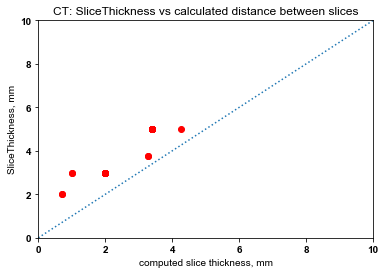

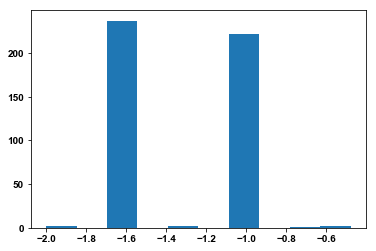

In [427]:
import matplotlib.pyplot as plt

CTvalidSeries=ctGeometryChecks_df[ctGeometryChecks_df["geometryOK"]==True]
plt.plot(CTvalidSeries["computedSliceThickness"], CTvalidSeries["SliceThickness"],'ro')
plt.plot(np.linspace(0,10),np.linspace(0,10),ls=':')
plt.axis([0,10,0,10])
plt.xlabel('computed slice thickness, mm')
plt.ylabel('SliceThickness, mm')
plt.title('CT: SliceThickness vs calculated distance between slices')
plt.show()

plt.hist(CTvalidSeries["computedSliceThickness"].values-CTvalidSeries["SliceThickness"].values)
plt.show()

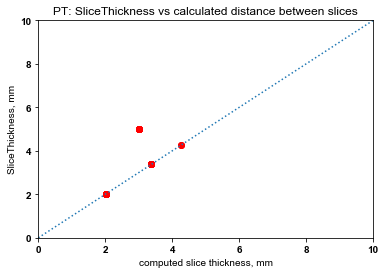

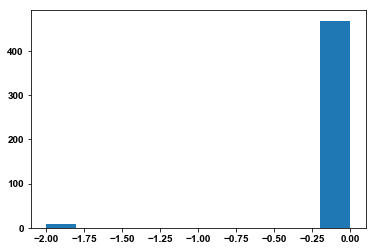

-1.000000e-07    258
-5.960409e-09    102
-5.960523e-09     38
 9.103829e-14     33
-5.960636e-09     14
-2.264855e-14     11
-2.000000e+00      8
-1.363354e-13      6
 0.000000e+00      2
-3.637091e-13      1
-5.000100e-03      1
-1.000001e-07      1
 3.419487e-14      1
dtype: int64

In [428]:
PTvalidSeries=ptGeometryChecks_df[ptGeometryChecks_df["geometryOK"]==True]
plt.plot(PTvalidSeries["computedSliceThickness"], PTvalidSeries["SliceThickness"],'ro')
plt.plot(np.linspace(0,10),np.linspace(0,10),ls=':')
plt.axis([0,10,0,10])
plt.xlabel('computed slice thickness, mm')
plt.ylabel('SliceThickness, mm')
plt.title('PT: SliceThickness vs calculated distance between slices')
plt.show()


plt.hist(PTvalidSeries["computedSliceThickness"].values-PTvalidSeries["SliceThickness"].values)
plt.show()
(PTvalidSeries["computedSliceThickness"]-PTvalidSeries["SliceThickness"]).value_counts()

## Exploring acquisition attributes

We can use any of the attributes stored in DICOM to subset the data, or to use it in the subsequent analysis.

As an example, we can see the histogram of the patient weight distribution:

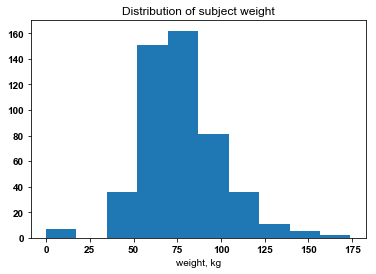

In [429]:
ct_df_noDuplicates = CT_df.drop_duplicates(subset="SeriesInstanceUID")

weight = ct_df_noDuplicates["PatientWeight"].values
weight[weight==np.nan] = 0
plt.hist(vals)
plt.xlabel("weight, kg")
plt.title("Distribution of subject weight")
plt.show()

Or explore some basic dependencies in the data.

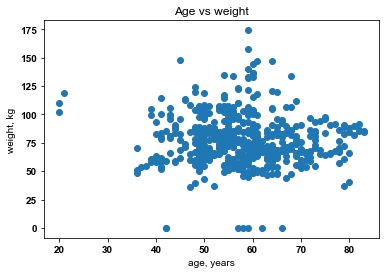

In [430]:
# Age is encoded as 048Y, so we need to strip off the suffix
age = [int(a[:-1]) for a in ct_df_noDuplicates["PatientAge"].values]
plt.scatter(age, weight)
plt.xlabel("age, years")
plt.ylabel("weight, kg")
plt.title("Age vs weight")
plt.show()

# Image segmentations



In [431]:
# select only those studies that have Segmentations
segSeries = CompositeContext_df[CompositeContext_df["Modality"]=="SEG"].drop_duplicates(subset="StudyInstanceUID")
print("This many studies include segmentations: %i " % (segSeries.shape[0]))
print("This many patients: %i" % segSeries["PatientID"].unique().shape)

This many studies include segmentations: 60 
This many patients: 59


In [432]:
print("List of subjects that have segmentations: "+str(segSeries["PatientID"].values))

List of subjects that have segmentations: ['QIN-HEADNECK-01-0003' 'QIN-HEADNECK-01-0017' 'QIN-HEADNECK-01-0024'
 'QIN-HEADNECK-01-0026' 'QIN-HEADNECK-01-0028' 'QIN-HEADNECK-01-0034'
 'QIN-HEADNECK-01-0041' 'QIN-HEADNECK-01-0046' 'QIN-HEADNECK-01-0047'
 'QIN-HEADNECK-01-0047' 'QIN-HEADNECK-01-0055' 'QIN-HEADNECK-01-0057'
 'QIN-HEADNECK-01-0060' 'QIN-HEADNECK-01-0062' 'QIN-HEADNECK-01-0064'
 'QIN-HEADNECK-01-0065' 'QIN-HEADNECK-01-0067' 'QIN-HEADNECK-01-0071'
 'QIN-HEADNECK-01-0074' 'QIN-HEADNECK-01-0079' 'QIN-HEADNECK-01-0081'
 'QIN-HEADNECK-01-0086' 'QIN-HEADNECK-01-0089' 'QIN-HEADNECK-01-0091'
 'QIN-HEADNECK-01-0098' 'QIN-HEADNECK-01-0100' 'QIN-HEADNECK-01-0112'
 'QIN-HEADNECK-01-0115' 'QIN-HEADNECK-01-0116' 'QIN-HEADNECK-01-0118'
 'QIN-HEADNECK-01-0120' 'QIN-HEADNECK-01-0127' 'QIN-HEADNECK-01-0129'
 'QIN-HEADNECK-01-0131' 'QIN-HEADNECK-01-0135' 'QIN-HEADNECK-01-0137'
 'QIN-HEADNECK-01-0139' 'QIN-HEADNECK-01-0140' 'QIN-HEADNECK-01-0157'
 'QIN-HEADNECK-01-0164' 'QIN-HEADNECK-01-0165' '

Segmentations are organized as follows: (a fragment from [the overall schema](https://app.quickdatabasediagrams.com/#/schema/_71V1H1AXEqqKWDnvx4VXw))

![](https://www.dropbox.com/s/lrcbl895cv64giu/seg_relationships.png?raw=1)

In [433]:
SEG_df = pd.read_csv(tablesPath+'/SEG.tsv', sep='\t', low_memory=False)
SEG_df.head()


,ClinicalTrialSeriesID,ClinicalTrialTimePointID,Columns,ContentCreatorName,NumberOfFrames,Rows,SOPInstanceUID,SegmentationType
0,1,1,512,Automated Aortic Arch Reference Region Segment...,12,512,1.2.276.0.7230010.3.1.4.8323329.18234.14400013...,BINARY
1,1,1,128,Automated Cerebellum Reference Region Segmenta...,14,128,1.2.276.0.7230010.3.1.4.8323329.18264.14400013...,BINARY
2,1,1,128,Automated Liver Reference Region Segmentation,17,128,1.2.276.0.7230010.3.1.4.8323329.18294.14400013...,BINARY
3,1,1,128,User1,13,128,1.2.276.0.7230010.3.1.4.8323329.18355.14400013...,BINARY
4,2,1,128,User1,13,128,1.2.276.0.7230010.3.1.4.8323329.18414.14400013...,BINARY


# **_TODO - look into this and all other merges!!!_**

In [434]:
CompositeContext_df.shape

(353252, 19)

In [435]:
SEG_df.shape

(900, 8)

In [436]:
SEG_merged = pd.merge(CompositeContext_df,SEG_df,on="SOPInstanceUID")
SEG_merged.shape

(900, 26)

In [437]:
SEG_Segments_df = pd.read_csv(tablesPath+'/SEG_Segments.tsv', sep='\t', low_memory=False)
SEG_merged = pd.merge(SEG_merged, SEG_Segments_df, on="SOPInstanceUID")

In [438]:
SEG_merged.head()


,BodyPartExamined,ManufacturerModelName,Modality,PatientAge,PatientID,PatientName,PatientSex,PatientWeight,SOPClassUID,SOPInstanceUID,...,SegmentAlgorithmName,SegmentAlgorithmType,SegmentLabel,SegmentNumber,SegmentedPropertyCategoryCodeSequence_CodeMeaning,SegmentedPropertyCategoryCodeSequence_CodeValue,SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator,SegmentedPropertyTypeCodeSequence_CodeMeaning,SegmentedPropertyTypeCodeSequence_CodeValue,SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator
0,HEADNECK,https://github.com/QIICR/Iowa2DICOM.git,SEG,048Y,QIN-HEADNECK-01-0003,QIN-HEADNECK-01-0003,M,75.0,Segmentation Storage,1.2.276.0.7230010.3.1.4.8323329.18234.14400013...,...,Iowa QIN Aortic Arch Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
1,HEADNECK,https://github.com/QIICR/Iowa2DICOM.git,SEG,048Y,QIN-HEADNECK-01-0003,QIN-HEADNECK-01-0003,M,75.0,Segmentation Storage,1.2.276.0.7230010.3.1.4.8323329.18264.14400013...,...,Iowa QIN Cerebellum Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
2,HEADNECK,https://github.com/QIICR/Iowa2DICOM.git,SEG,048Y,QIN-HEADNECK-01-0003,QIN-HEADNECK-01-0003,M,75.0,Segmentation Storage,1.2.276.0.7230010.3.1.4.8323329.18294.14400013...,...,Iowa QIN Liver Segmentation,AUTOMATIC,Reference Region,1,Spatial and Relational Concept,R-42018,SRT,Reference Region,C94970,NCIt
3,HEADNECK,https://github.com/QIICR/Iowa2DICOM.git,SEG,048Y,QIN-HEADNECK-01-0003,QIN-HEADNECK-01-0003,M,75.0,Segmentation Storage,1.2.276.0.7230010.3.1.4.8323329.18355.14400013...,...,NaN,MANUAL,"Neoplasm, Primary",1,Morphologically Altered Structure,M-01000,SRT,"Neoplasm, Primary",M-80003,SRT
4,HEADNECK,https://github.com/QIICR/Iowa2DICOM.git,SEG,048Y,QIN-HEADNECK-01-0003,QIN-HEADNECK-01-0003,M,75.0,Segmentation Storage,1.2.276.0.7230010.3.1.4.8323329.18414.14400013...,...,NaN,MANUAL,"Neoplasm, Primary",1,Morphologically Altered Structure,M-01000,SRT,"Neoplasm, Primary",M-80003,SRT


lymph node of head and neck    2052
pharyngeal tonsil (adenoid)     300
base of tongue                  264
Liver                            60
Aortic arch                      60
Cerebellum                       60
oropharynx                       60
nasopharynx                      36
hypopharynx                      24
pyriform sinus                   24
Name: AnatomicRegionSequence_CodeMeaning, dtype: int64

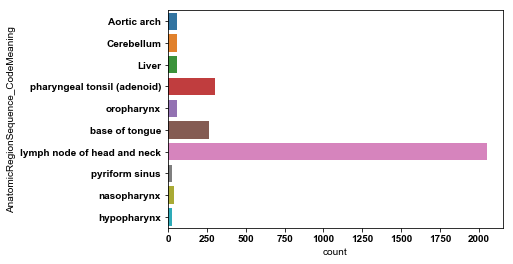

In [439]:

%matplotlib inline
import seaborn as sns
import matplotlib
sns.countplot(y="AnatomicRegionSequence_CodeMeaning",data=SEG_merged)
SEG_merged["AnatomicRegionSequence_CodeMeaning"].value_counts()

In [440]:
SEG_merged.columns

Index(['BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime',
       'ClinicalTrialSeriesID', 'ClinicalTrialTimePointID', 'Columns',
       'ContentCreatorName', 'NumberOfFrames', 'Rows', 'SegmentationType',
       'AnatomicRegionSequence_CodeMeaning',
       'AnatomicRegionSequence_CodeValue',
       'AnatomicRegionSequence_CodingSchemeDesignator', 'SegmentAlgorithmName',
       'SegmentAlgorithmType', 'SegmentLabel', 'SegmentNumber',
       'SegmentedPropertyCategoryCodeSequence_CodeMeaning',
       'SegmentedPropertyCategoryCodeSequence_CodeValue',
       'SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator',
       'SegmentedPropertyTypeCodeSequence_CodeMeaning',
       'SegmentedProper

In [441]:
SEG_merged["SeriesDescription"].value_counts()

tumor segmentation - User2 SemiAuto trial 1    230
tumor segmentation - User2 SemiAuto trial 2    230
tumor segmentation - User1 SemiAuto trial 1    230
tumor segmentation - User2 Manual trial 2      230
tumor segmentation - User3 SemiAuto trial 1    230
tumor segmentation - User3 SemiAuto trial 2    230
tumor segmentation - User1 Manual trial 1      230
tumor segmentation - User1 Manual trial 2      230
tumor segmentation - User3 Manual trial 2      230
tumor segmentation - User2 Manual trial 1      230
tumor segmentation - User3 Manual trial 1      230
tumor segmentation - User1 SemiAuto trial 2    230
auto liver segmentation                         59
auto aorta segmentation                         57
auto cerebellum segmentation                    57
manual aorta segmentation                        3
manual cerebellum segmentation                   3
manual liver segmentation                        1
Name: SeriesDescription, dtype: int64

In [442]:
SEG_merged["SegmentAlgorithmName"].value_counts()

Iowa QIN PET Tumor Segmentation 1.0    1380
Iowa QIN Liver Segmentation              59
Iowa QIN Cerebellum Segmentation         57
Iowa QIN Aortic Arch Segmentation        57
Name: SegmentAlgorithmName, dtype: int64

In [443]:
SEG_merged["SegmentAlgorithmType"].value_counts()

MANUAL           1387
SEMIAUTOMATIC    1380
AUTOMATIC         173
Name: SegmentAlgorithmType, dtype: int64

lymph node of head and neck    171
pharyngeal tonsil (adenoid)     25
base of tongue                  22
oropharynx                       5
nasopharynx                      3
hypopharynx                      2
pyriform sinus                   2
Name: AnatomicRegionSequence_CodeMeaning, dtype: int64

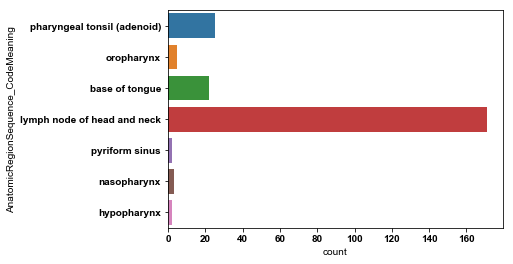

In [444]:
oneReaderOneSession = SEG_merged[SEG_merged["SeriesDescription"]=="tumor segmentation - User1 SemiAuto trial 1"]
sns.countplot(y="AnatomicRegionSequence_CodeMeaning",data=oneReaderOneSession)
oneReaderOneSession["AnatomicRegionSequence_CodeMeaning"].value_counts()

Let's figure out how many tumor structures were segmented in each of the studies. 

`SEG_merged` table has one row per segment, and each row contains `PatientID`, because of the way we constructed it. So we can just count the number of times each of the `PatientID`s is encountered.


In [445]:
SEG_merged["PatientID"].value_counts()


QIN-HEADNECK-01-0067    147
QIN-HEADNECK-01-0139    135
QIN-HEADNECK-01-0366    123
QIN-HEADNECK-01-0057    111
QIN-HEADNECK-01-0239    111
QIN-HEADNECK-01-0047    102
QIN-HEADNECK-01-0190     99
QIN-HEADNECK-01-0135     87
QIN-HEADNECK-01-0180     87
QIN-HEADNECK-01-0100     75
QIN-HEADNECK-01-0201     75
QIN-HEADNECK-01-0089     75
QIN-HEADNECK-01-0112     75
QIN-HEADNECK-01-0228     63
QIN-HEADNECK-01-0165     63
QIN-HEADNECK-01-0074     51
QIN-HEADNECK-01-0064     51
QIN-HEADNECK-01-0129     51
QIN-HEADNECK-01-0244     51
QIN-HEADNECK-01-0203     51
QIN-HEADNECK-01-0079     51
QIN-HEADNECK-01-0086     51
QIN-HEADNECK-01-0186     51
QIN-HEADNECK-01-0220     51
QIN-HEADNECK-01-0071     51
QIN-HEADNECK-01-0140     51
QIN-HEADNECK-01-0118     51
QIN-HEADNECK-01-0026     51
QIN-HEADNECK-01-0028     39
QIN-HEADNECK-01-0041     39
QIN-HEADNECK-01-0120     39
QIN-HEADNECK-01-0275     39
QIN-HEADNECK-01-0199     39
QIN-HEADNECK-01-0224     39
QIN-HEADNECK-01-0184     39
QIN-HEADNECK-01-0212

In [446]:
SEG_merged[SEG_merged["PatientID"] == "QIN-HEADNECK-01-0067"]["SeriesDescription"].value_counts()

tumor segmentation - User3 SemiAuto trial 1    12
tumor segmentation - User3 Manual trial 1      12
tumor segmentation - User3 SemiAuto trial 2    12
tumor segmentation - User1 SemiAuto trial 2    12
tumor segmentation - User2 Manual trial 2      12
tumor segmentation - User1 Manual trial 2      12
tumor segmentation - User1 SemiAuto trial 1    12
tumor segmentation - User2 Manual trial 1      12
tumor segmentation - User3 Manual trial 2      12
tumor segmentation - User2 SemiAuto trial 1    12
tumor segmentation - User2 SemiAuto trial 2    12
tumor segmentation - User1 Manual trial 1      12
auto aorta segmentation                         1
auto liver segmentation                         1
auto cerebellum segmentation                    1
Name: SeriesDescription, dtype: int64

# Segmentation-based measurements



In [447]:
SR_df = pd.read_csv(tablesPath+'/SR.tsv', sep='\t', low_memory=False)
SR1500_MeasurementGroups_df = pd.read_csv(tablesPath+'/SR1500_MeasurementGroups.tsv', sep='\t', low_memory=False)
SR1500_Measurements_df = pd.read_csv(tablesPath+'/SR1500_Measurements.tsv', sep='\t', low_memory=False)

In [448]:
SR_df.columns

Index(['CompletionFlag', 'SOPInstanceUID', 'TemplateIdentifier',
       'VerificationFlag'],
      dtype='object')

In [449]:
SR1500_MeasurementGroups_df.columns

Index(['DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'SOPInstanceUID', 'TrackingIdentifier', 'TrackingUniqueIdentifier',
       'activitySession', 'measurementMethod_CodeMeaning',
       'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint'],
      dtype='object')

In [450]:
SR1500_Measurements_df.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value'],
      dtype='object')

In [451]:
SR1500_MeasurementGroups_df.shape

(2940, 17)

In [452]:
SR1500_Measurements_df.shape

(60531, 12)

In [453]:
SR1500_MeasurementGroups_df["TrackingUniqueIdentifier"].shape
SR1500_MeasurementGroups_df["TrackingUniqueIdentifier"].unique().shape
SR1500_MeasurementGroups_df["TrackingUniqueIdentifier"].value_counts()

2.25.119742469174657312445054997629845321644    12
2.25.74485136242183500549820712998905264044     12
2.25.105182251810631622677618135192565659564    12
2.25.64540722311818720812778811496939337644     12
2.25.129196200910685749145365555255074305964    12
2.25.50439330290264013534570304849406015404     12
2.25.14003837753151496831378884648834643884     12
2.25.99750201817230754594452439579794290604     12
2.25.6917788947837840730875328111268804524      12
2.25.103079984808902877894036258209407121324    12
2.25.10875853645092955655506078073364625324     12
2.25.320370907695967723830130278572037715884    12
2.25.45524878674850459511546607799619237804     12
2.25.148854382121548657707777160917106505644    12
2.25.127380548125105356744175330995772274604    12
2.25.66856991711033119855991234108910942124     12
2.25.59199116019617636326836401916113532844     12
2.25.37019651447091917750681815574462281644     12
2.25.79680478631285376499488305157576275884     12
2.25.11598818485736026139521847

Note that `SOPInstanceUID` is attached to every item to link to the DICOM instance where it comes from. `TrackingUniqueIdentifier` is unique for every structure being segmented, and comes up 12 times for each finding that is not a reference region: had 3 users, with each user segmenting the same structure using manual or semi-automatic approaches, on 2 occasions - 3x2x2 = 12.

Since measurements for the segmentations produced using each combination of user/segmentation method/segmentation session is stored into a separate series, we can uniquely match attributes of the MeasurementGroup with the individual measurements by merging on the combination of `SOPInstanceUID` and `TrackingUniqueIdentifier` keys.

In [454]:
SR_merged = pd.merge(SR1500_Measurements_df,SR1500_MeasurementGroups_df,on=["SOPInstanceUID","TrackingUniqueIdentifier"])
SR_merged.shape

(60531, 27)

In [455]:
SR_merged.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value', 'DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'TrackingIdentifier', 'activitySession',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint'],
      dtype='object')

In [456]:
SR_merged["PersonObserverName"].value_counts()

User3    19712
User2    19694
User1    19685
User4       48
User5        8
Name: PersonObserverName, dtype: int64

Didn't expect to see `User4` and `User5` ... what are they?

In [457]:
SR_merged[SR_merged["PersonObserverName"].isin(["User4","User5"])]["FindingSite_CodeMeaning"]

2152     Aortic arch
2153     Aortic arch
2154     Aortic arch
2155     Aortic arch
2156     Aortic arch
2157     Aortic arch
2158     Aortic arch
2159     Aortic arch
6963           Liver
6964           Liver
6965           Liver
6966           Liver
6967           Liver
6968           Liver
6969           Liver
6970           Liver
35589    Aortic arch
35590    Aortic arch
35591    Aortic arch
35592    Aortic arch
35593    Aortic arch
35594    Aortic arch
35595    Aortic arch
35596    Aortic arch
35597     Cerebellum
35598     Cerebellum
35599     Cerebellum
35600     Cerebellum
35601     Cerebellum
35602     Cerebellum
35603     Cerebellum
35604     Cerebellum
36665     Cerebellum
36666     Cerebellum
36667     Cerebellum
36668     Cerebellum
36669     Cerebellum
36670     Cerebellum
36671     Cerebellum
36672     Cerebellum
57158    Aortic arch
57159    Aortic arch
57160    Aortic arch
57161    Aortic arch
57162    Aortic arch
57163    Aortic arch
57164    Aortic arch
57165    Aort

Now let's add all of the composite context information so that we know what patient each measurement belongs to.

In [458]:
SR_merged=pd.merge(SR_merged, CompositeContext_df, on="SOPInstanceUID")
SR_merged.shape

(60531, 45)

In [459]:
SR_merged.columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value', 'DeviceObserverName', 'FindingSite_CodeMeaning',
       'FindingSite_CodeValue', 'FindingSite_CodingSchemeDesignator',
       'Finding_CodeMeaning', 'Finding_CodeValue',
       'Finding_CodingSchemeDesignator', 'ObserverType', 'PersonObserverName',
       'TrackingIdentifier', 'activitySession',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'timePoint',
       'BodyPartExamined', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight',
       'SOPClassUID', 'SeriesDate', 'SeriesDescription', 'Serie

## Plot measurements

Each finding was expected to be segmented by each of the 3 users, using automated or manual approach, two times each (12 segmentations total). Each finding is assigned a unique identifier, so we can look at the consistency of the segmentation across readers, across segmentation approaches, and across segmentation sessions.

But first, let's check and confirm that we have all 12 sets of measurements for each of the unique tracking identifier. Let's only consider primary and secondary neoplasms.



In [460]:
SR_merged["Finding_CodeMeaning"].unique()

array(['Reference Region', 'Neoplasm, Primary', 'Neoplasm, Secondary'], dtype=object)

In [461]:
SR_merged.groupby(['quantity_CodeMeaning','derivationModifier_CodeMeaning']).size().reset_index().rename(columns={0:'count'})

,quantity_CodeMeaning,derivationModifier_CodeMeaning,count
0,SUVbw,25th Percentile Value,2940
1,SUVbw,75th Percentile Value,2940
2,SUVbw,Maximum,2940
3,SUVbw,Mean,2940
4,SUVbw,Median,2940
5,SUVbw,Minimum,2940
6,SUVbw,Peak Value Within ROI,1131
7,SUVbw,RMS,2760
8,SUVbw,Standard Deviation,2940
9,SUVbw,Upper Adjacent Value,2760


In [462]:
SR_merged.groupby(['quantity_CodeMeaning']).size().reset_index().rename(columns={0:'count'})

,quantity_CodeMeaning,count
0,Glycolysis Within First Quarter of Intensity R...,2760
1,Glycolysis Within Fourth Quarter of Intensity ...,2760
2,Glycolysis Within Second Quarter of Intensity ...,2760
3,Glycolysis Within Third Quarter of Intensity R...,2760
4,Percent Within First Quarter of Intensity Range,2760
5,Percent Within Fourth Quarter of Intensity Range,2760
6,Percent Within Second Quarter of Intensity Range,2760
7,Percent Within Third Quarter of Intensity Range,2760
8,SUVbw,27231
9,Standardized Added Metabolic Activity,2760


In [463]:
SR_merged["quantity_CodeMeaning"].unique()

array(['SUVbw', 'Volume', 'Total Lesion Glycolysis',
       'Glycolysis Within First Quarter of Intensity Range',
       'Glycolysis Within Second Quarter of Intensity Range',
       'Glycolysis Within Third Quarter of Intensity Range',
       'Glycolysis Within Fourth Quarter of Intensity Range',
       'Percent Within First Quarter of Intensity Range',
       'Percent Within Second Quarter of Intensity Range',
       'Percent Within Third Quarter of Intensity Range',
       'Percent Within Fourth Quarter of Intensity Range',
       'Standardized Added Metabolic Activity',
       'Standardized Added Metabolic Activity Background'], dtype=object)

In [464]:
SR_merged["derivationModifier_CodeMeaning"].unique()

array(['Mean', 'Minimum', 'Maximum', nan, 'Standard Deviation',
       '25th Percentile Value', 'Median', '75th Percentile Value',
       'Peak Value Within ROI', 'Upper Adjacent Value', 'RMS'], dtype=object)

Observe how for some measurements we have 12 items for a given finding type (and there is always Primary tumor present):

In [465]:
SR_merged[SR_merged["Finding_CodeMeaning"]=="Neoplasm, Primary"][SR_merged["quantity_CodeMeaning"]=="Volume"]["PatientID"].shape[0]/12

/Users/fedorov/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


59.0

... and for others less than that, since some of the measurements cannot always be computed!

In [466]:
SR_merged[SR_merged["Finding_CodeMeaning"]=="Neoplasm, Primary"][SR_merged["derivationModifier_CodeMeaning"]=="Peak Value Within ROI"]["PatientID"].shape[0]/12

/Users/fedorov/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


46.916666666666664

Who has more than one time point?

In [467]:
# exporting stuff for Steve
#SR_merged[SR_merged["timePoint"]==2]['PatientID'].unique()
#SEG_merged["SeriesInstanceUID"].head()[0]
#SEG_merged[["SeriesInstanceUID","PatientID","SeriesDescription"]].head()
#forSteve.to_json("/Users/fedorov/Downloads/seg.json")

Since we have volume of the primary tumor available for every subject, let's see how much it varies across users, tools and segmentation sessions.


Lets factor out the segmentation tool type - unfortunately, it is easily accessible only from the series description!

In [468]:
SR_merged["segmentationToolType"] = \
 SR_merged["SeriesDescription"].apply(lambda toolType: toolType.split(" ")[-3] if toolType.split(" ")[-3] in ["Manual","SemiAuto"] else "Auto")
SR_merged["segmentationToolType"]

0            Auto
1            Auto
2            Auto
3            Auto
4            Auto
5            Auto
6            Auto
7            Auto
8            Auto
9            Auto
10           Auto
11           Auto
12           Auto
13           Auto
14           Auto
15           Auto
16           Auto
17           Auto
18           Auto
19           Auto
20           Auto
21           Auto
22           Auto
23           Auto
24         Manual
25         Manual
26         Manual
27         Manual
28         Manual
29         Manual
           ...   
60501    SemiAuto
60502    SemiAuto
60503    SemiAuto
60504    SemiAuto
60505    SemiAuto
60506    SemiAuto
60507    SemiAuto
60508    SemiAuto
60509    SemiAuto
60510    SemiAuto
60511    SemiAuto
60512    SemiAuto
60513    SemiAuto
60514    SemiAuto
60515    SemiAuto
60516    SemiAuto
60517    SemiAuto
60518    SemiAuto
60519    SemiAuto
60520    SemiAuto
60521    SemiAuto
60522    SemiAuto
60523    SemiAuto
60524    SemiAuto
60525    S

In [492]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB

output_notebook()

volume = []
user = []
method = []
sesssion = []
subject = []

subset = SR_merged[SR_merged["PersonObserverName"]=="User1"]
subset = subset[subset["Finding_CodeMeaning"]=="Neoplasm, Primary"]
subset = subset[subset["quantity_CodeMeaning"]=="Volume"]
subset = subset[subset["activitySession"]==1]
#subset = subset[subset["segmentationToolType"]=="SemiAuto"]

#subset.sort_values("value", inplace=True)

volumes = subset["value"].values
users = subset["PersonObserverName"].values
subjects = subset["PatientID"].values
#subjects

colormap = {'1-Manual': 'red', '2-Manual': 'red', '1-SemiAuto': 'blue', '2-SemiAuto': 'blue'}
colors = [colormap[x] for x in (subset["activitySession"].map(str)+'-'+subset['segmentationToolType']).tolist()]

#source=ColumnDataSource(data=dict(x=subject,y=volume))

p = figure(x_range=[np.min(volumes),np.max(volumes)],y_range=subjects.tolist())
p.yaxis.axis_label = "PatientID"
p.xaxis.axis_label = subset["quantity_CodeMeaning"].values[0]+', '+subset['units_CodeMeaning'].values[0]
#p.xaxis.axis_label = subset[""]
p.circle(volumes, subjects) #,color=colors)
show(p)

Loading BokehJS ...

In [34]:
#subset = SR_merged[SR_merged["PersonObserverName"]=="User1"]
subset = SR_merged[SR_merged["Finding_CodeMeaning"]=="Neoplasm, Primary"]
subset = subset[subset["quantity_CodeMeaning"]=="Volume"]
subset = subset[subset["activitySession"]==1]
#subset = subset[subset["segmentationToolType"]=="SemiAuto"]

#subset.sort_values("value", inplace=True)

volumes = subset["value"].values
users = subset["PersonObserverName"].values
subjects = subset["PatientID"].values
#subjects

colormap = {'User1-Manual': 'red', 'User2-Manual': 'red', 'User3-Manual': 'red', 'User1-SemiAuto': 'blue', 'User2-SemiAuto': 'blue', 'User3-SemiAuto': 'blue'}
colors = [colormap[x] for x in (subset["PersonObserverName"].map(str)+'-'+subset['segmentationToolType']).tolist()]

#source=ColumnDataSource(data=dict(x=subject,y=volume))

p = figure(x_range=[np.min(volumes),np.max(volumes)],y_range=subjects.tolist())
p.yaxis.axis_label = "PatientID"
p.xaxis.axis_label = subset["quantity_CodeMeaning"].values[0]+', '+subset['units_CodeMeaning'].values[0]
#p.xaxis.axis_label = subset[""]
p.circle(volumes, subjects,color=colors)
show(p)

# TODO: subset by tumor location?

NameError: name 'SR_merged' is not defined

In [497]:
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

output_notebook()

p = figure(plot_width=400, plot_height=400,
           tools="tap", title="Click the Dots")

source = ColumnDataSource(data=dict(
    x=[1, 2, 3, 4, 5],
    y=[2, 5, 8, 2, 7],
    color=["navy", "orange", "olive", "firebrick", "gold"]
    ))

p.circle('x', 'y', color='color', size=20, source=source)

url = "http://www.colors.commutercreative.com/@color/"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(p)

Loading BokehJS ...

In [500]:
sorted(SEG_merged["PatientID"].unique())

['QIN-HEADNECK-01-0003',
 'QIN-HEADNECK-01-0017',
 'QIN-HEADNECK-01-0024',
 'QIN-HEADNECK-01-0026',
 'QIN-HEADNECK-01-0028',
 'QIN-HEADNECK-01-0034',
 'QIN-HEADNECK-01-0041',
 'QIN-HEADNECK-01-0046',
 'QIN-HEADNECK-01-0047',
 'QIN-HEADNECK-01-0055',
 'QIN-HEADNECK-01-0057',
 'QIN-HEADNECK-01-0060',
 'QIN-HEADNECK-01-0062',
 'QIN-HEADNECK-01-0064',
 'QIN-HEADNECK-01-0065',
 'QIN-HEADNECK-01-0067',
 'QIN-HEADNECK-01-0071',
 'QIN-HEADNECK-01-0074',
 'QIN-HEADNECK-01-0079',
 'QIN-HEADNECK-01-0081',
 'QIN-HEADNECK-01-0086',
 'QIN-HEADNECK-01-0089',
 'QIN-HEADNECK-01-0091',
 'QIN-HEADNECK-01-0098',
 'QIN-HEADNECK-01-0100',
 'QIN-HEADNECK-01-0112',
 'QIN-HEADNECK-01-0115',
 'QIN-HEADNECK-01-0116',
 'QIN-HEADNECK-01-0118',
 'QIN-HEADNECK-01-0120',
 'QIN-HEADNECK-01-0127',
 'QIN-HEADNECK-01-0129',
 'QIN-HEADNECK-01-0131',
 'QIN-HEADNECK-01-0135',
 'QIN-HEADNECK-01-0137',
 'QIN-HEADNECK-01-0139',
 'QIN-HEADNECK-01-0140',
 'QIN-HEADNECK-01-0157',
 'QIN-HEADNECK-01-0164',
 'QIN-HEADNECK-01-0165',
